# Benchmark ELEP for phase picking surface events

We will test the ELEP workflow to phase picks the SU events picked by the PNSN.
This notebooks focuses on the multiband workflow (a bit complicated!)

In [2]:
# import sys
# sys.path.append('/data/wsd01/pnwstore/')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import obspy
from obspy.core import UTCDateTime
from obspy.clients.fdsn.client import Client

import scipy
from scipy import optimize
from scipy.optimize import curve_fit
from geopy import distance
from datetime import datetime
from utils import *
import torch
import gc
plt.rcParams.update({'font.size': 10})


import seisbench.models as sbm
device = torch.device("cpu")

from ELEP.elep.ensemble_statistics import ensemble_statistics
from ELEP.elep.ensemble_coherence import ensemble_semblance 
from ELEP.elep.ensemble_learners import ensemble_regressor_cnn
from ELEP.elep import mbf, mbf_utils
from ELEP.elep import trigger_func

from ELEP.elep.mbf_utils import make_LogFq, make_LinFq, rec_filter_coeff, create_obspy_trace
from ELEP.elep.mbf import MB_filter

In [3]:
# define clients to download the station data
# client = WaveformClient() # we ignore PNWdatastore for now
client2 = Client('IRIS')

t_before = 15 #number of seconds before pick time
# t_after = 15 #number of seconds after pick time
t_before_raw = 1200 #number of seconds before pick time before removing instrumental response
# t_after_raw = 1200 #number of seconds after pick time before removing instrumental response
fs = 40 #sampling rate that all waveforms are resampled to
window = 150 #window length of the signal (this will help with phase picking with EqT next). 
# Use 150 seconds @ 40 Hz gives 6001 points. 
pr = 98 #percentile
thr = 5 #SNR threshold
station_distance_threshold = 25
pi = np.pi
v_s = 1000 #shear wave velocity at the surface

# range of dates that we are looking at
t_beginning = UTCDateTime(2001,1,1,0,0,0) 
t_end = UTCDateTime(2023,8,2,23,59)
twin=6000

smooth_length = 5 # constant for smoothing the waveform envelopes
low_cut = 1 #low frequency threshold
high_cut = 12 #high frequency threshold
az_thr = 1000 #threshold of distance in meters from source location
step = 100 #step every 100 m
t_step = 1 #step every second
ratio = 5.6915196 #used to define the grid 
colors = list(plt.cm.tab10(np.arange(10)))*3
radius = 6371e3 # radius of the earth

In [4]:

# ML picker parameters
paras_semblance = {'dt':0.025, 'semblance_order':4, 'window_flag':True, 
                   'semblance_win':0.5, 'weight_flag':'max'}
p_thrd, s_thrd = 0.01, 0.05

In [5]:
# download models
pretrain_list = ["pnw","ethz","instance","scedc","stead","geofon","neic"]
pn_pnw_model = sbm.EQTransformer.from_pretrained('pnw')
pn_ethz_model = sbm.EQTransformer.from_pretrained("ethz")
pn_instance_model = sbm.EQTransformer.from_pretrained("instance")
pn_scedc_model = sbm.EQTransformer.from_pretrained("scedc")
pn_stead_model = sbm.EQTransformer.from_pretrained("stead")
pn_geofon_model = sbm.EQTransformer.from_pretrained("geofon")
pn_neic_model = sbm.EQTransformer.from_pretrained("neic")

In [6]:
pn_pnw_model.to(device);
pn_ethz_model.to(device);
pn_scedc_model.to(device);
pn_neic_model.to(device);
pn_geofon_model.to(device);
pn_stead_model.to(device);
pn_instance_model.to(device);

## volcano info

In [7]:
#this data includes all stations within 50km of each volcano and the lat, lon, elev of each station
df = pd.read_csv('../data/station/Volcano_Metadata_50km.csv')

### 3. Surface Event Data from PNSN

Read files straight from PNSN data base. Extract station and network code, phase pick time (seen as start_time). this should be converted to pick_time0.

In [8]:
f1 = pd.read_csv("../data/events/su_picks.txt",sep="|")
f1.head()
print(f1.keys())

Index(['date', 'net', 'sta', 'location', 'seedchan', 'iphase', 'quality',
       'orid', 'etype', 'evid'],
      dtype='object')


In [9]:
# clean up the spaces in the file
format='%Y/%m/%d %H:%M:%S'
test=f1["date"].values.tolist()
start_time_temp = [  datetime.strptime(x.strip(),'%Y/%m/%d %H:%M:%S') for x in f1["date"].values.tolist()]
# # Ignore events prior to t_beginning
ik=np.where(np.array(start_time_temp)>datetime(2001,1,1))[0][0]

# select only net, sta, evid, startime for event past the start date.

start_time = start_time_temp[ik:]
net=[ x.strip() for x in f1["net"].values.tolist()][ik:]
sta=[ x.strip() for x in f1["sta"].values.tolist()][ik:]
evt_id=[ x for x in f1["orid"].values.tolist()][ik:]
all_stas=set(sta)

## Multiband parameters

In [10]:
fqmin = low_cut
fqmax = high_cut
dt = 0.025; fs = 40
nfqs = 10
nt = 6000; nc = 3
fq_list = make_LogFq(fqmin, fqmax, dt, nfqs)
coeff_HP, coeff_LP = rec_filter_coeff(fq_list, dt)
MBF_paras = {'f_min':fqmin, 'f_max':fqmax, 'nfqs':nfqs, 'frequencies':fq_list, 'CN_HP':coeff_HP, 'CN_LP':coeff_LP, \
    'dt':dt, 'fs':fs, 'nt':nt, 'nc':nc, 'npoles': 2}

3113398 2020-01-10T06:35:04.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


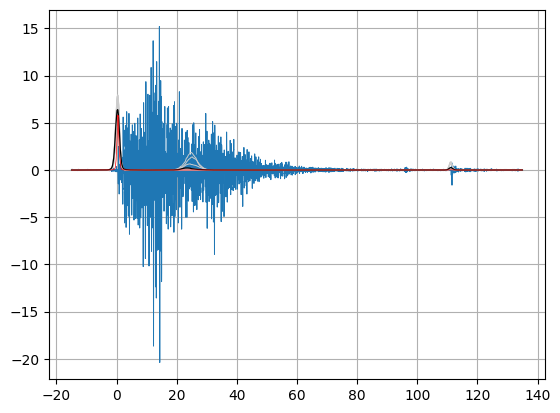

3113708 2020-01-15T01:39:08.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


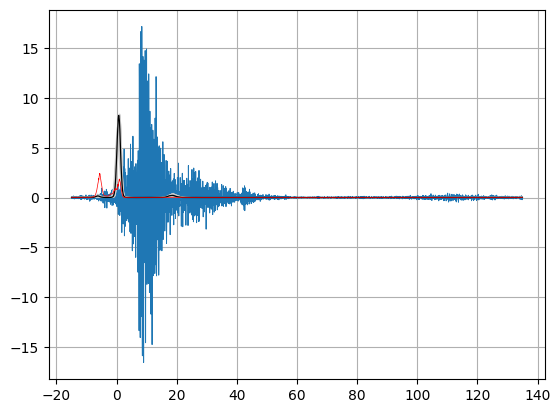

3114128 2020-01-25T19:40:57.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


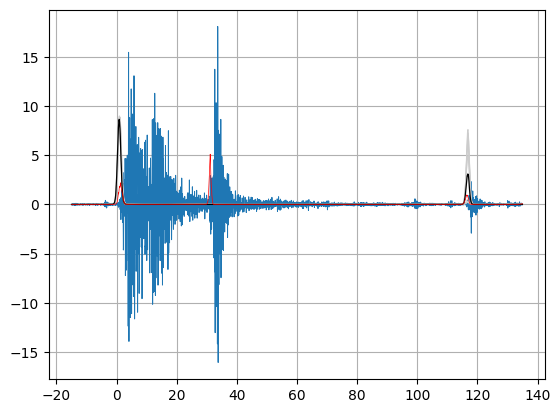

3114333 2020-01-26T18:07:33.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


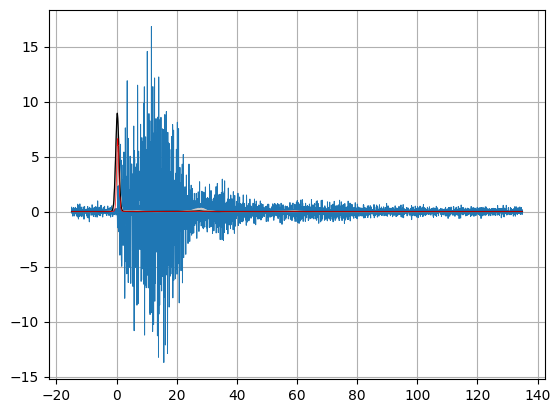

3114323 2020-01-27T03:44:58.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


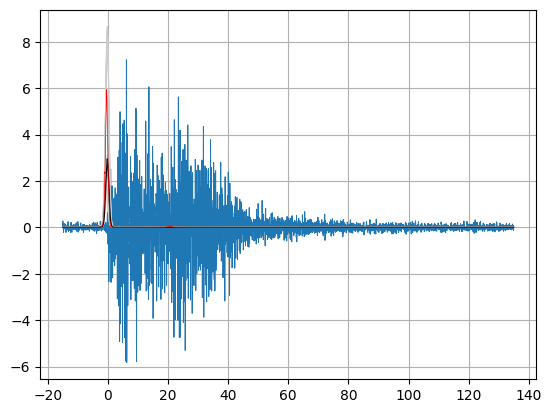

3114288 2020-01-27T05:12:07.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


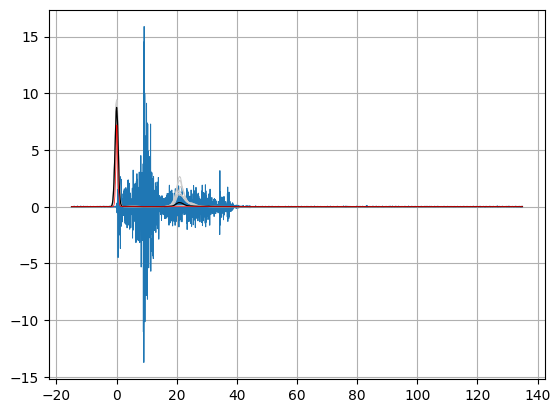

3114298 2020-01-27T18:23:06.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


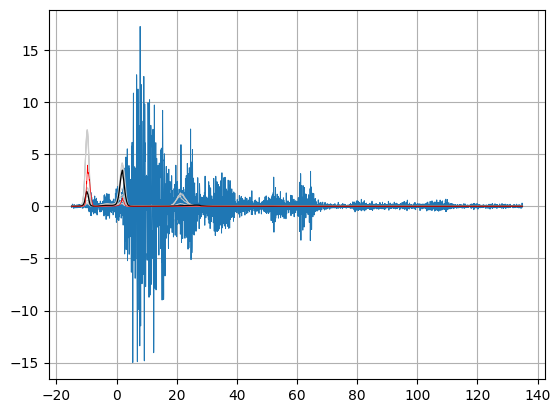

3114368 2020-01-28T04:06:32.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


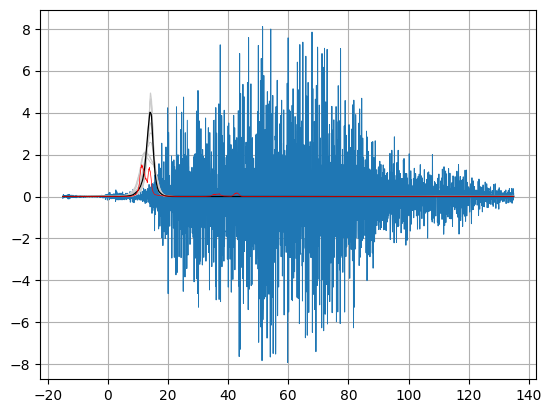

3114398 2020-01-29T04:28:27.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


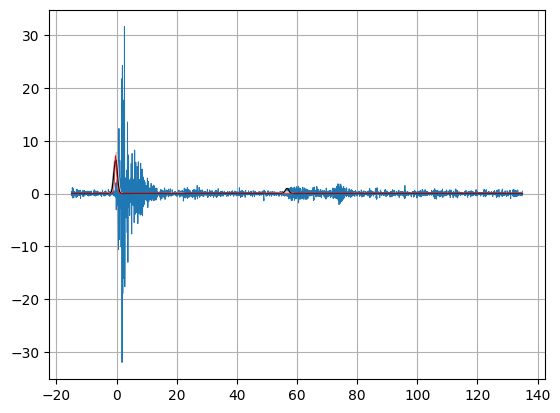

3114398 2020-01-29T04:28:27.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


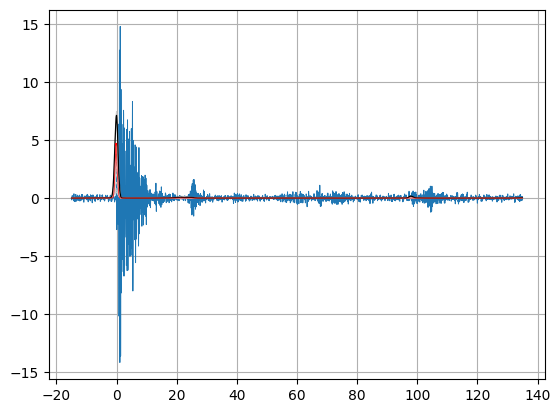

3114398 2020-01-29T04:28:28.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


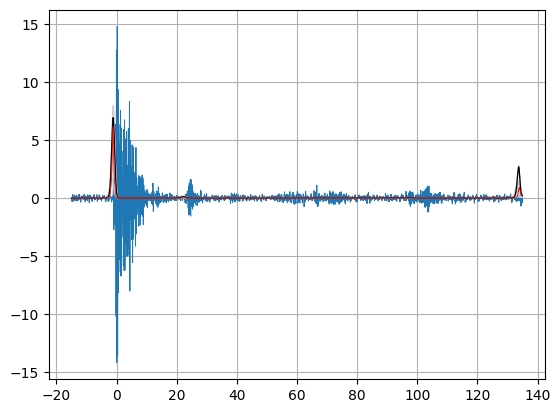

3114398 2020-01-29T04:28:28.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


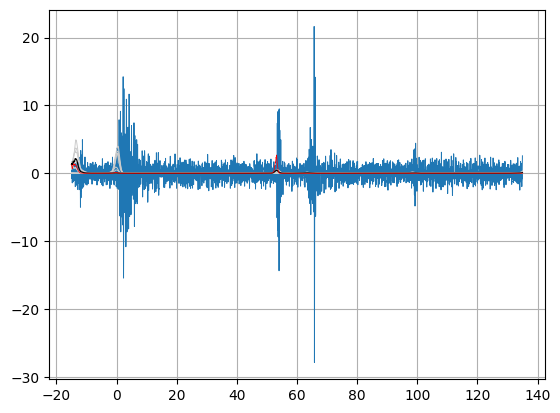

3114398 2020-01-29T04:28:29.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


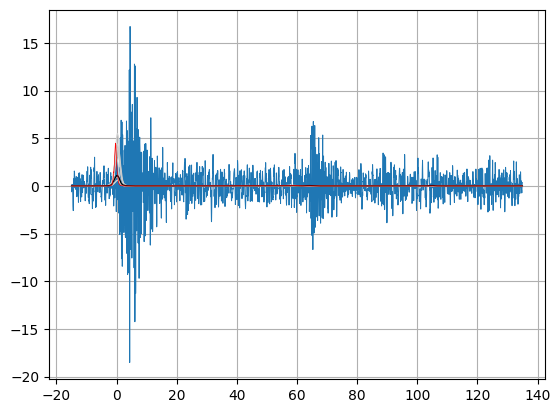

3114398 2020-01-29T04:28:29.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


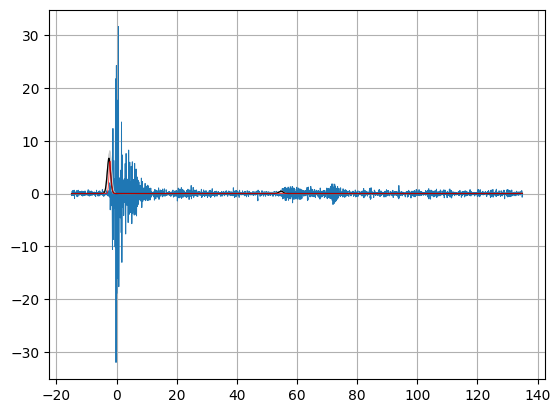

3114518 2020-01-30T03:10:51.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


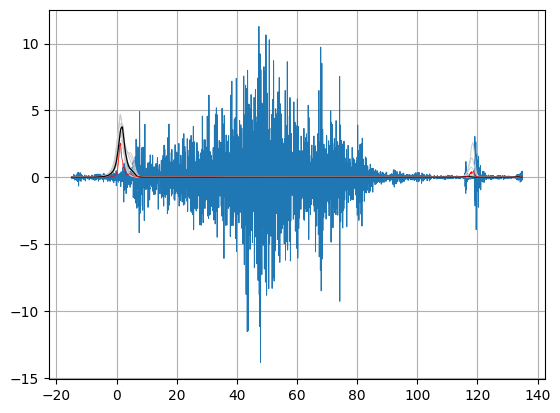

3114603 2020-01-31T03:24:40.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


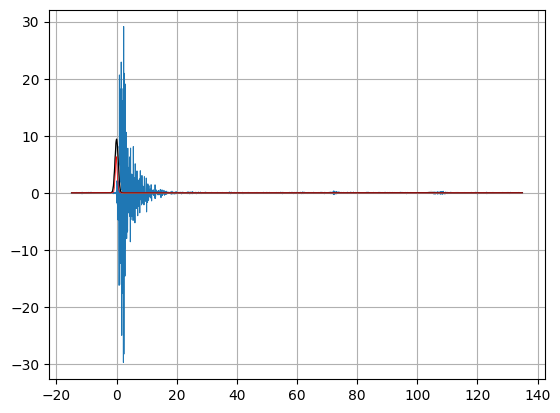

3114593 2020-01-31T04:21:03.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


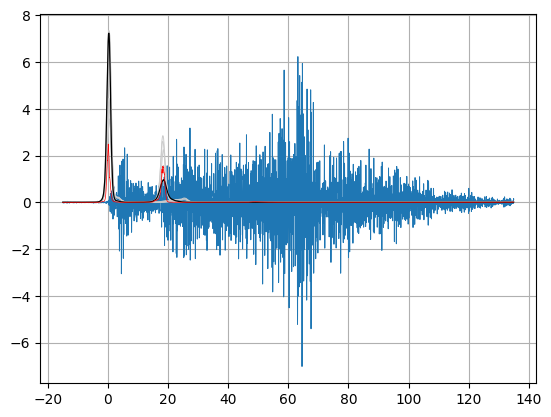

3114588 2020-01-31T11:12:08.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


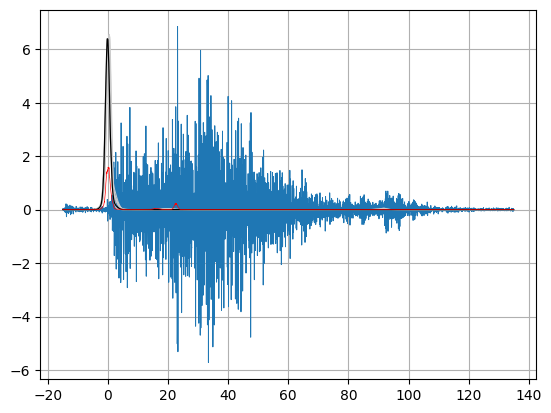

3114623 2020-01-31T18:27:42.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


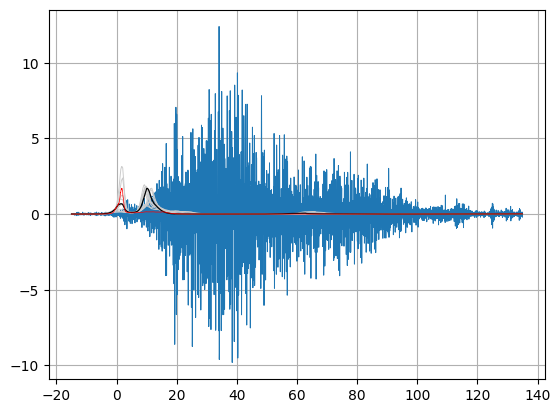

3114798 2020-02-02T00:35:19.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


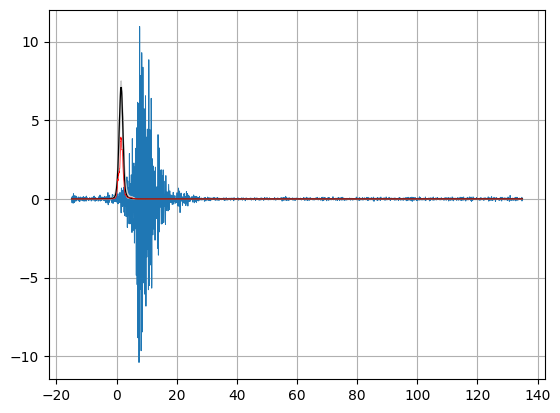

3114823 2020-02-02T01:37:55.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


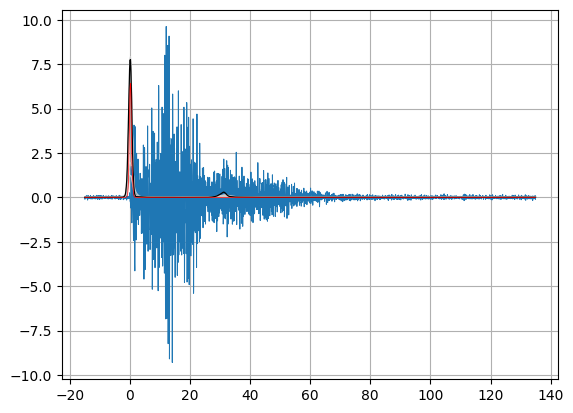

3114673 2020-02-02T02:42:48.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


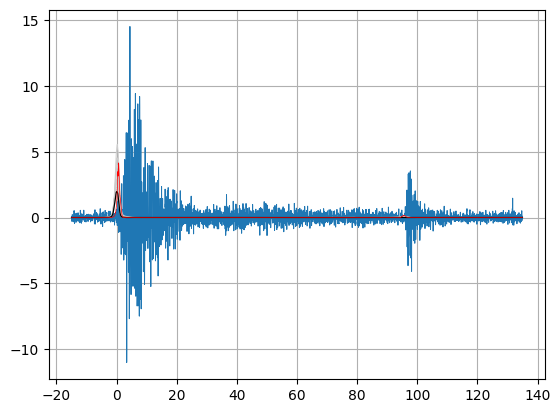

3114838 2020-02-02T04:19:05.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


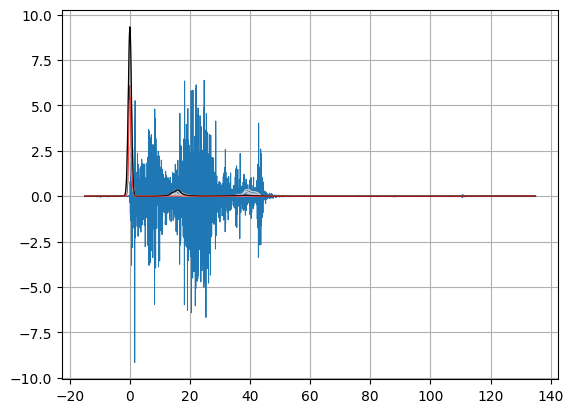

3114703 2020-02-02T06:27:00.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


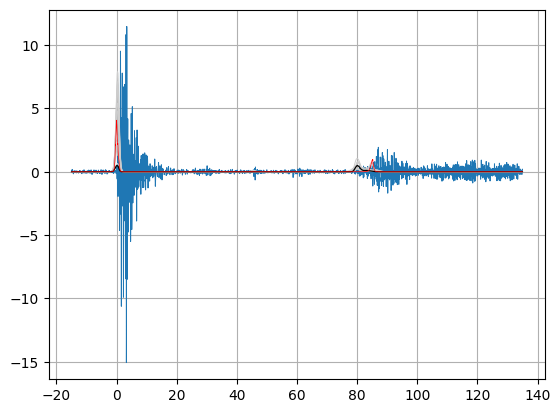

3114843 2020-02-02T09:19:08.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


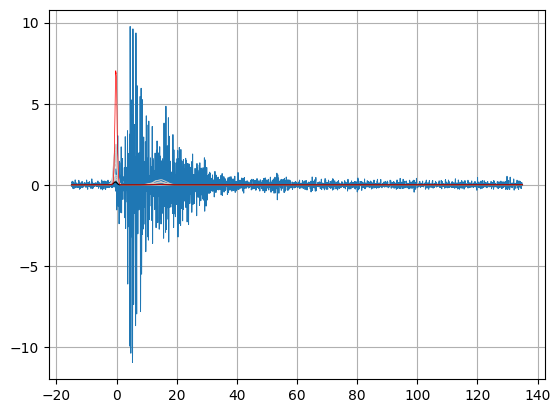

3114853 2020-02-02T11:50:37.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


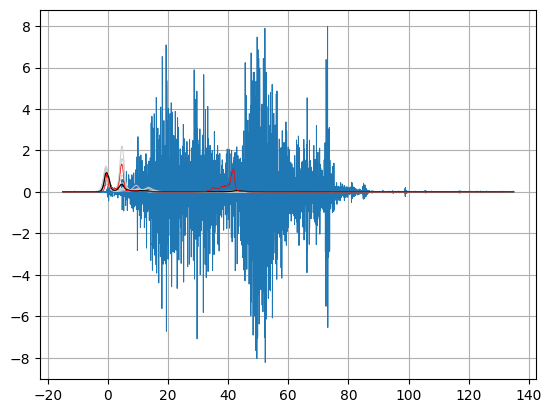

3114728 2020-02-02T12:43:20.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


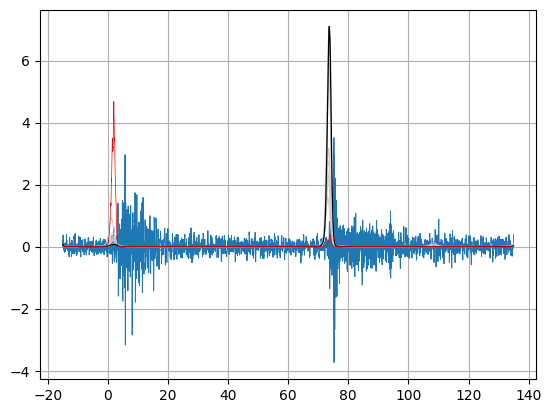

3114733 2020-02-02T12:57:42.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


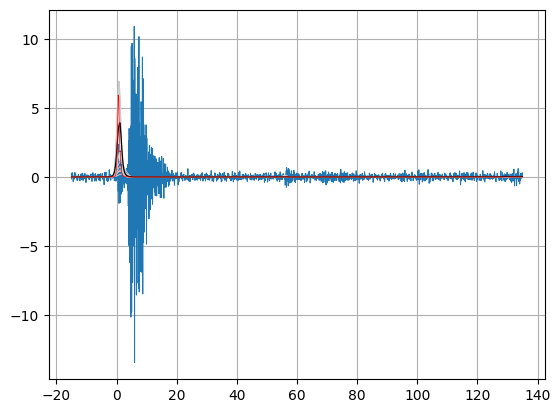

3114858 2020-02-03T02:51:59.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


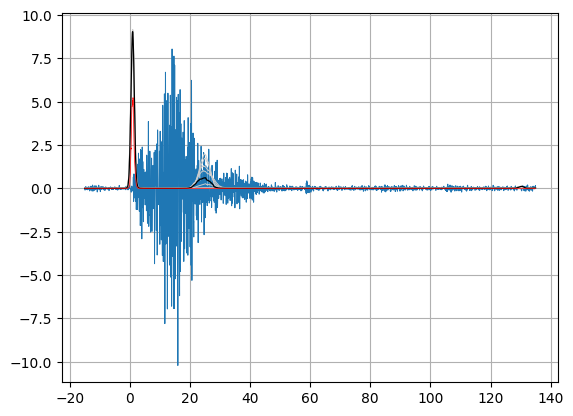

3114753 2020-02-03T12:01:55.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


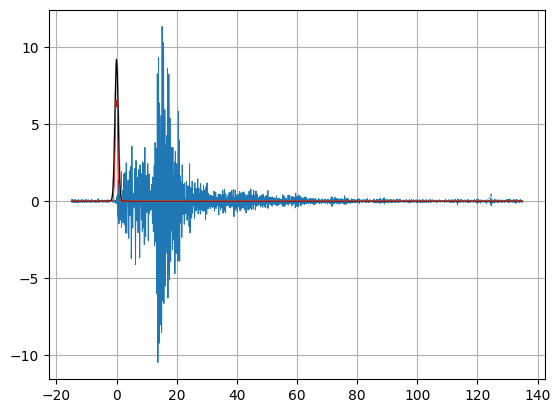

3115338 2020-02-09T04:57:48.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


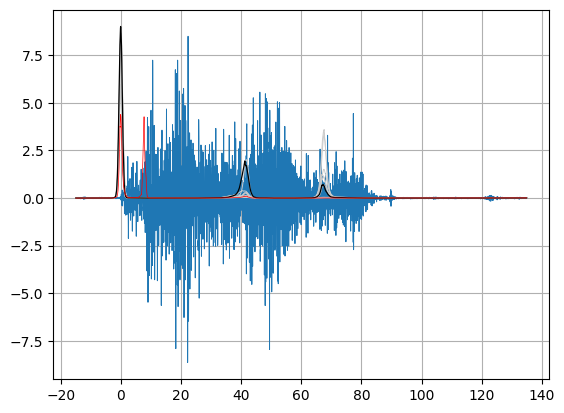

3115263 2020-02-14T00:16:44.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


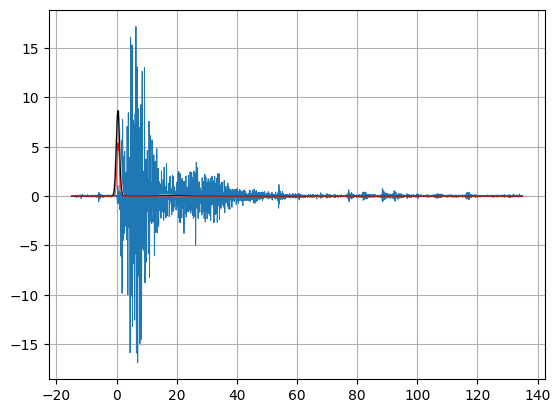

3115288 2020-02-14T13:37:29.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


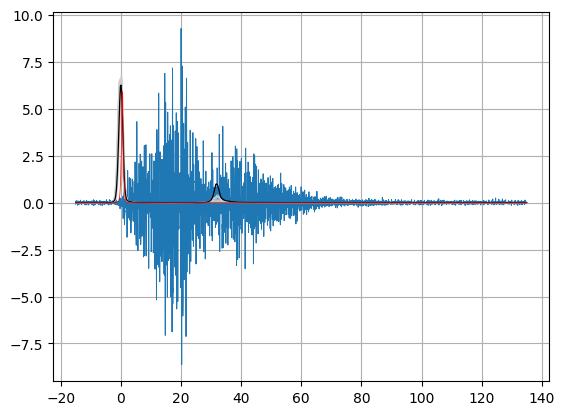

3116243 2020-02-22T21:59:48.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


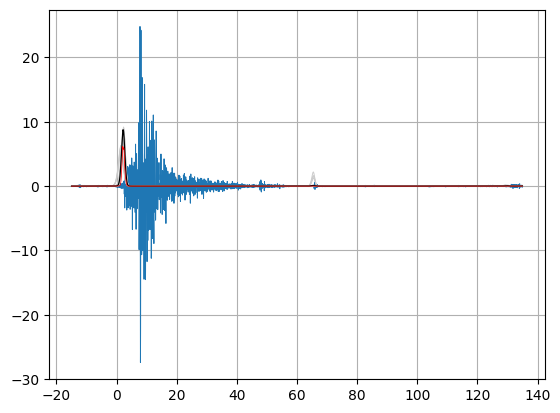

3116253 2020-02-22T23:51:08.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


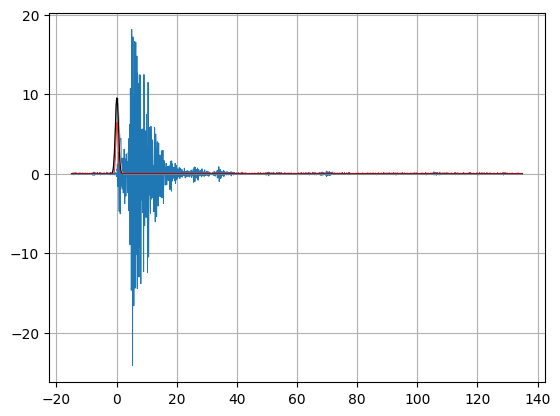

3116133 2020-02-25T06:19:54.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


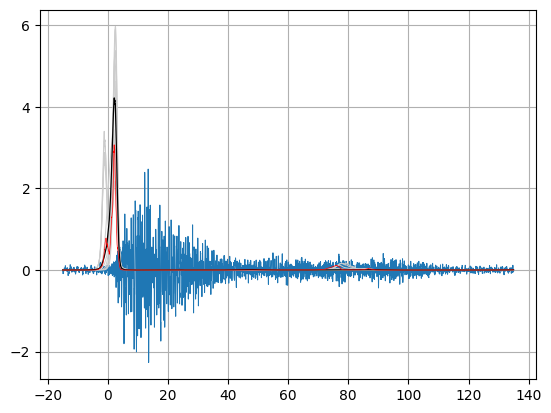

3116103 2020-02-25T11:44:11.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


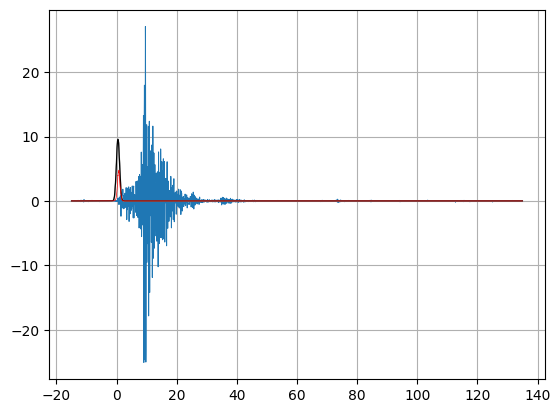

3116153 2020-02-26T00:06:31.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


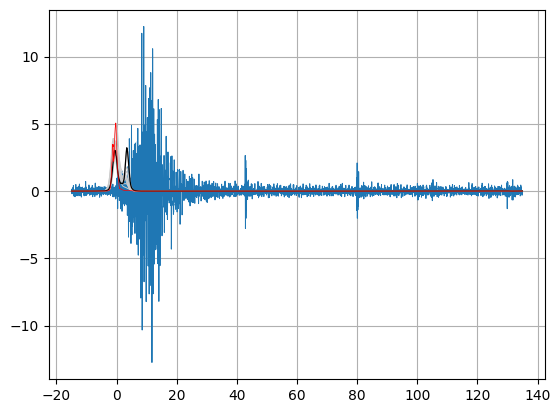

3116323 2020-02-27T02:41:35.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


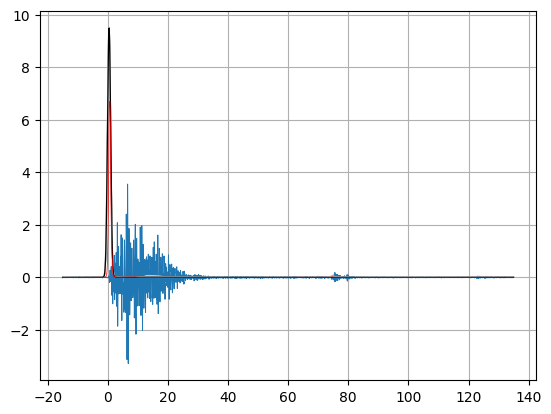

3116318 2020-02-27T10:47:58.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


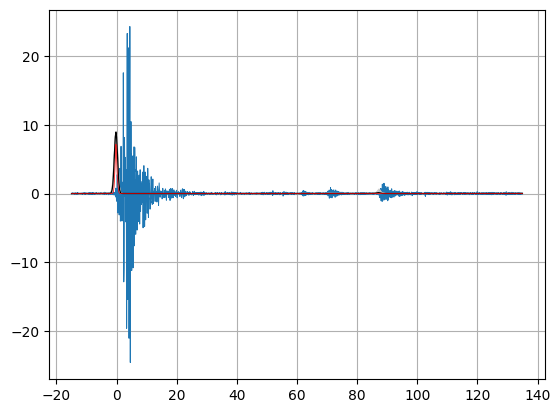

3116383 2020-02-28T00:56:03.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


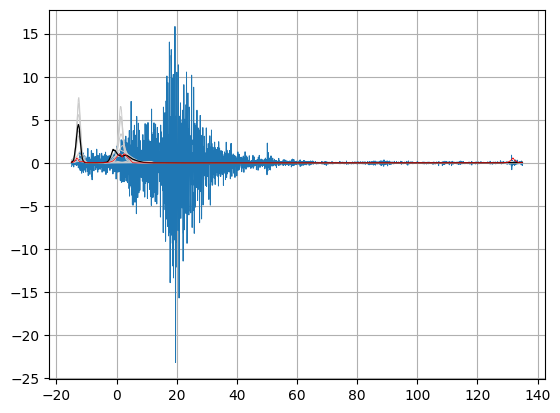

3116393 2020-02-28T08:38:24.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


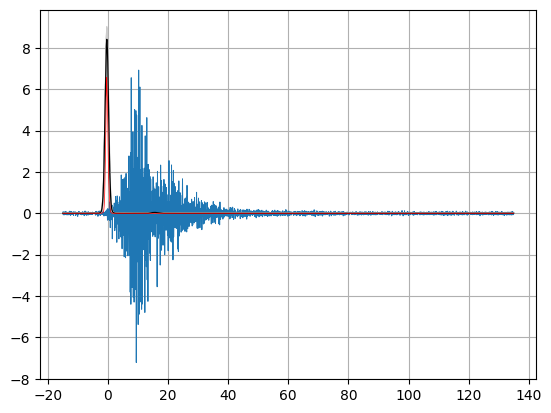

3116398 2020-02-28T10:04:41.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


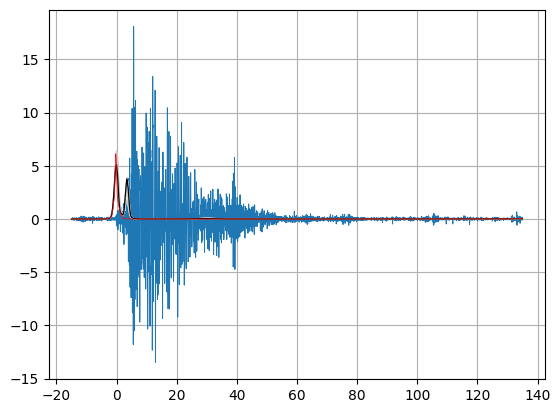

3116403 2020-02-28T12:27:13.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


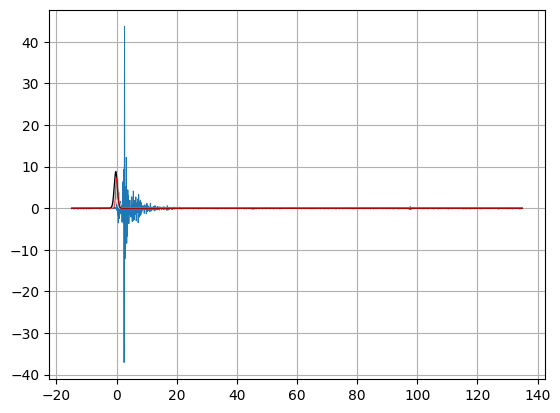

3116408 2020-02-28T13:16:38.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


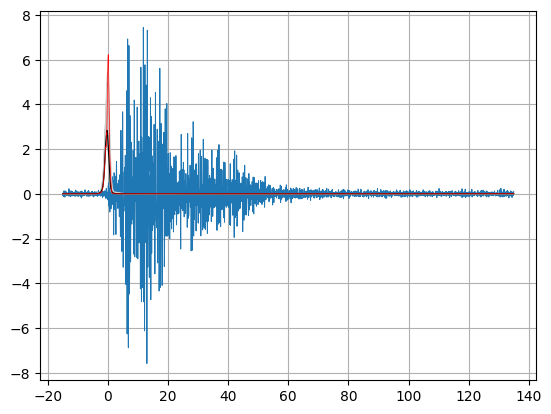

3116413 2020-02-28T13:19:55.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


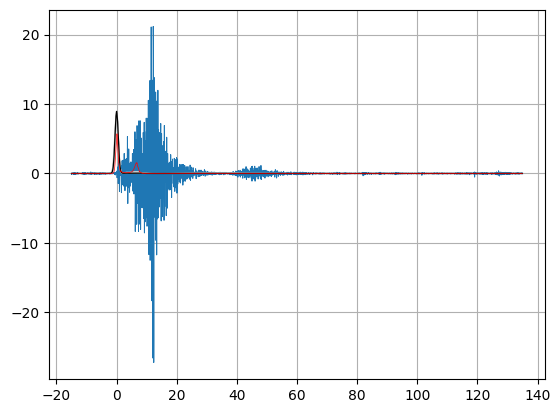

3116423 2020-02-28T15:25:47.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


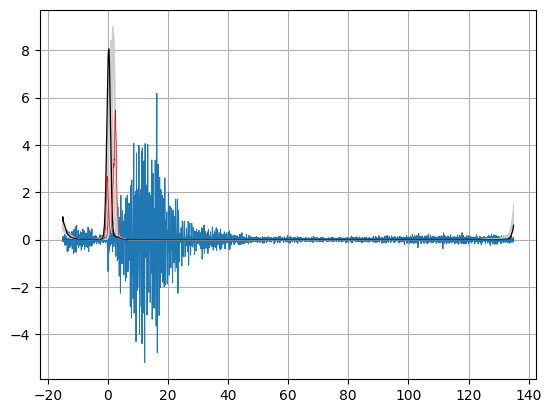

3116663 2020-02-29T22:09:54.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


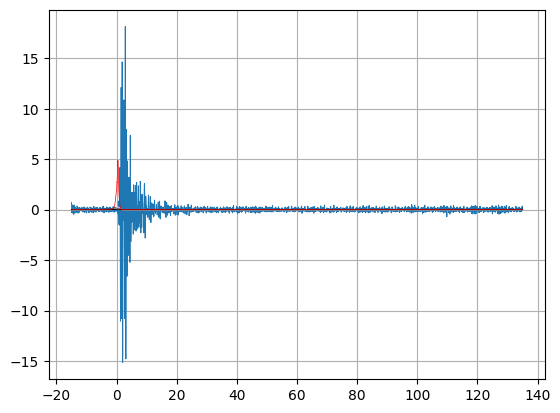

3116543 2020-03-01T10:41:04.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


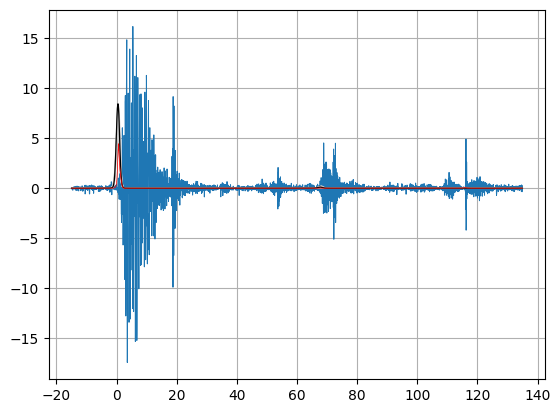

3116643 2020-03-03T15:38:04.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


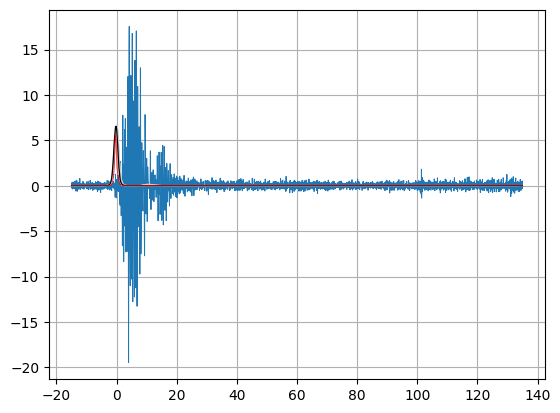

3116793 2020-03-05T00:19:05.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


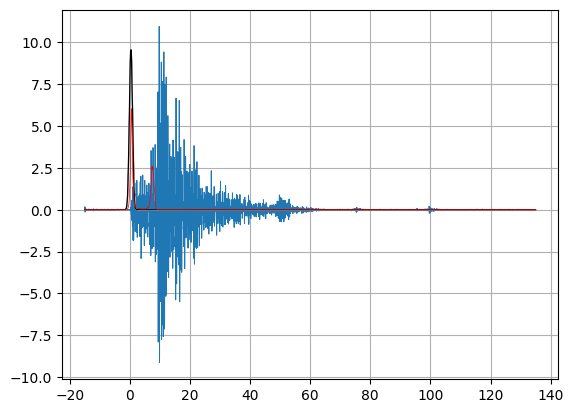

3116743 2020-03-05T11:42:42.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


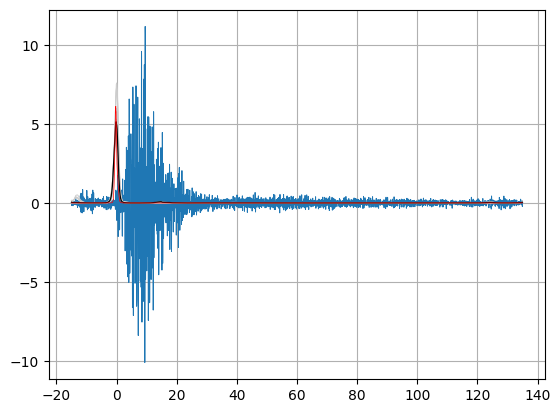

3117918 2020-03-07T04:53:00.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


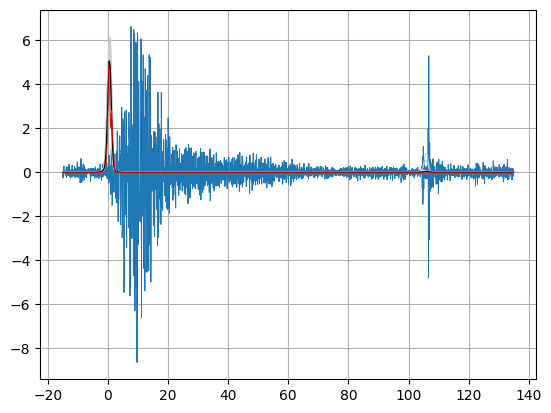

3117943 2020-03-07T23:36:17.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


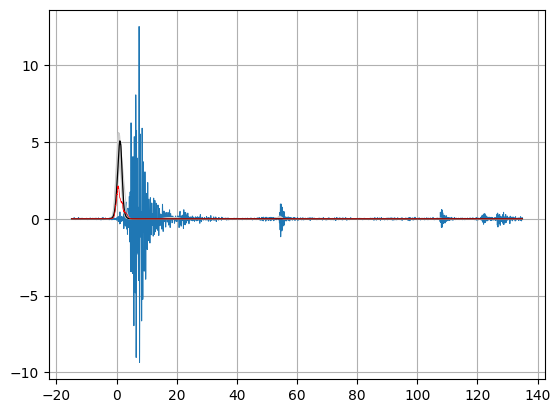

3117443 2020-03-08T04:04:39.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


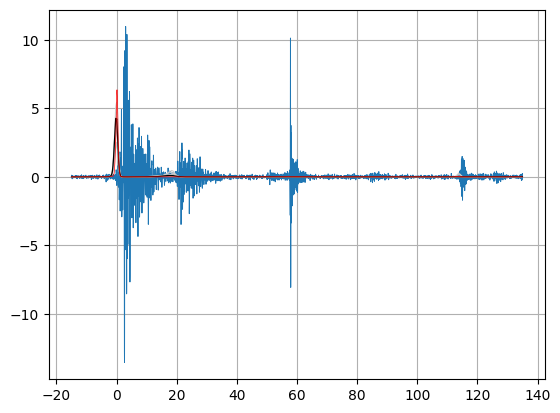

3119638 2020-03-08T07:25:15.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


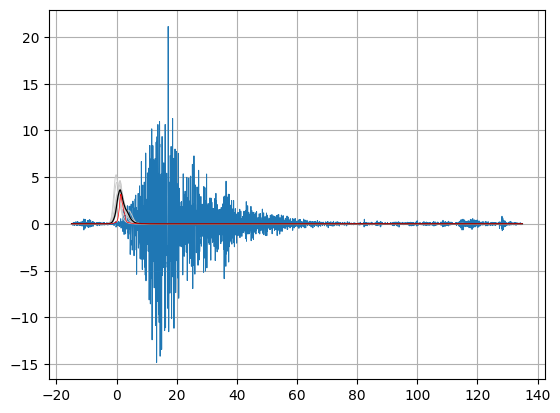

3119643 2020-03-08T08:58:46.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


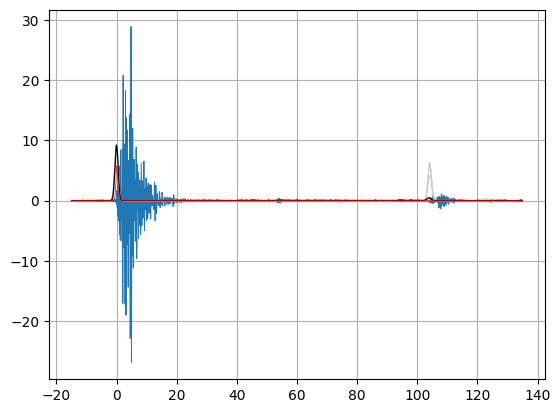

3119798 2020-03-08T12:35:49.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


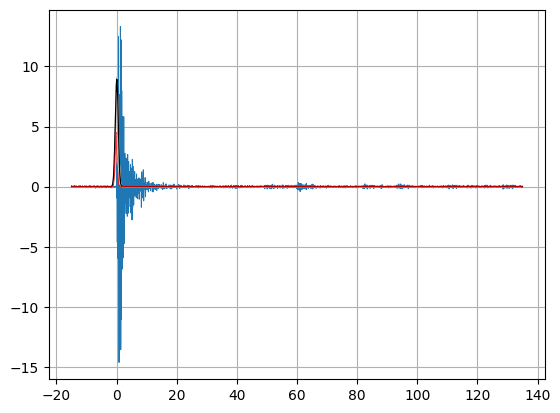

3119798 2020-03-08T12:35:49.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


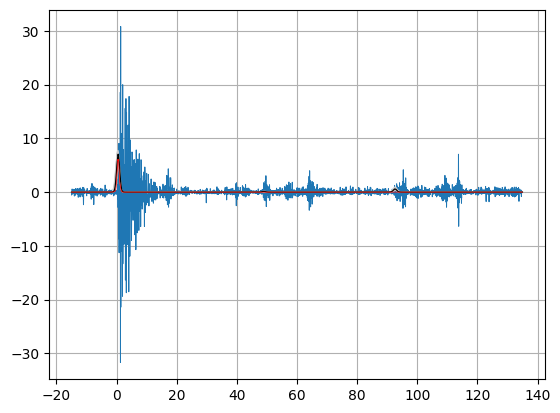

3119798 2020-03-08T12:35:49.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


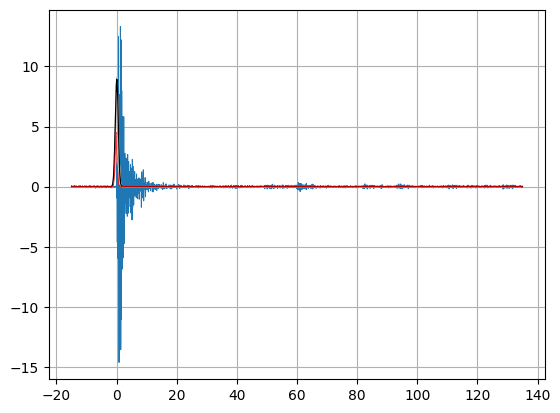

3119798 2020-03-08T12:35:50.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


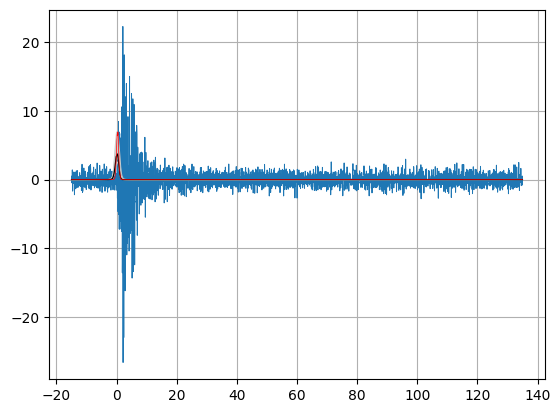

3119798 2020-03-08T12:35:50.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


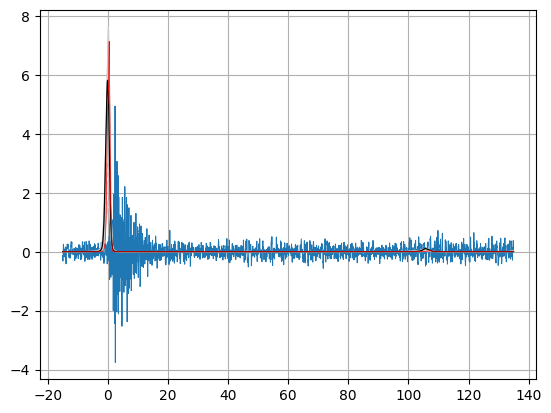

3119798 2020-03-08T12:35:52.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


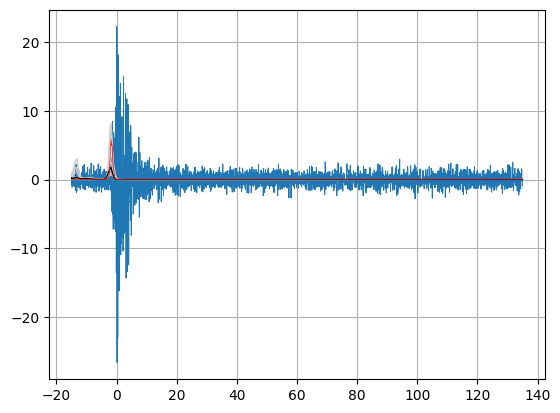

3117563 2020-03-08T13:06:58.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


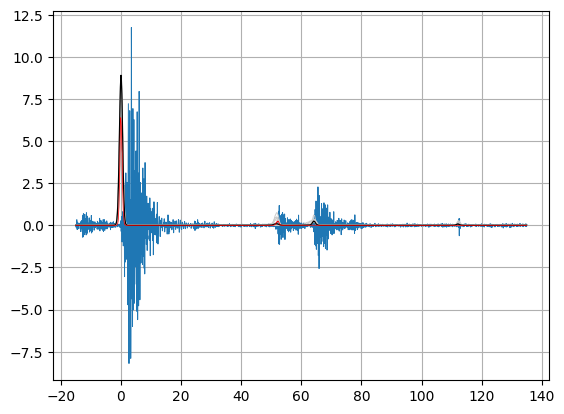

3117533 2020-03-08T13:24:47.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


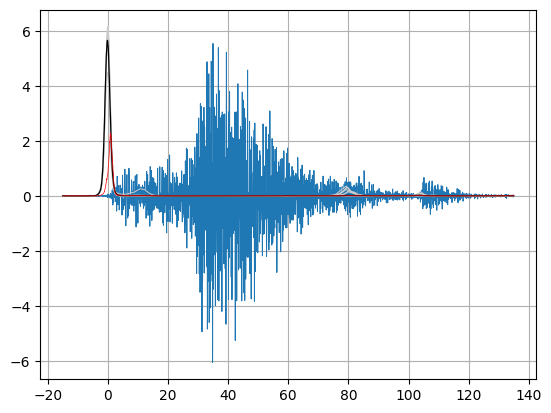

3119808 2020-03-08T13:56:53.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


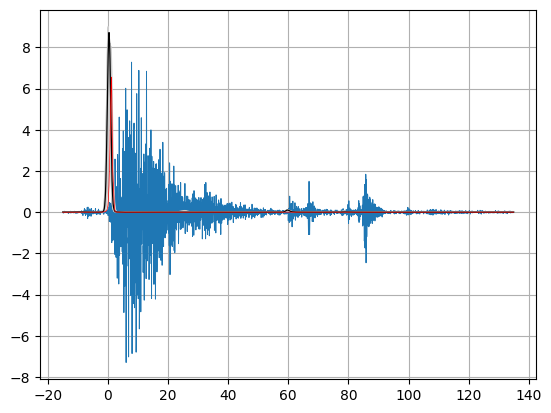

3117103 2020-03-09T00:19:52.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


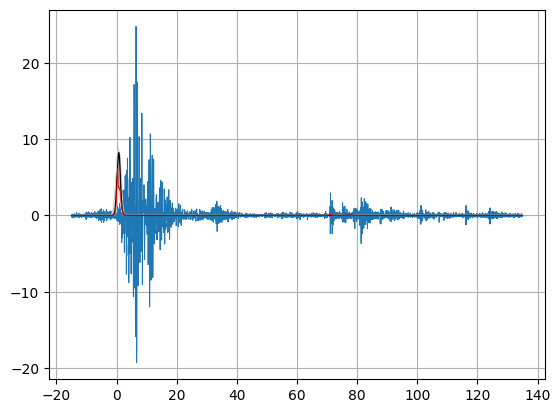

3117113 2020-03-09T01:13:30.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


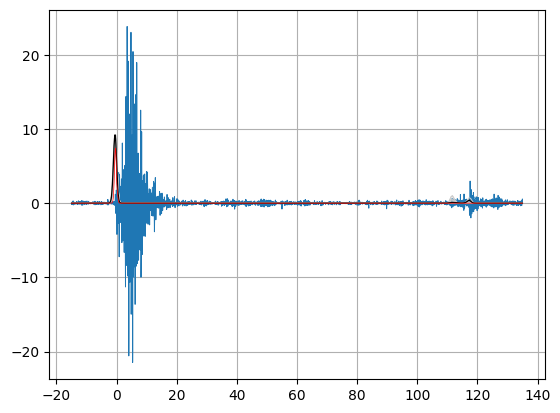

3117118 2020-03-09T02:51:44.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


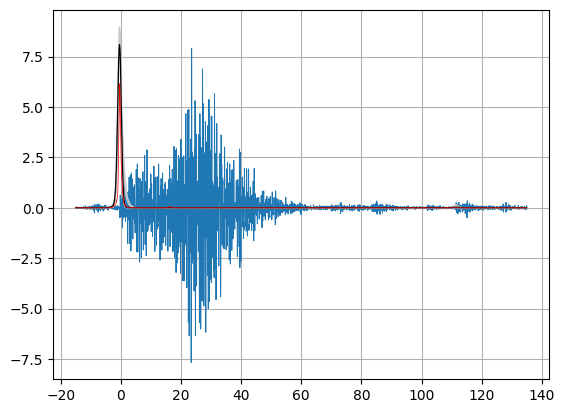

3117043 2020-03-09T14:50:06.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


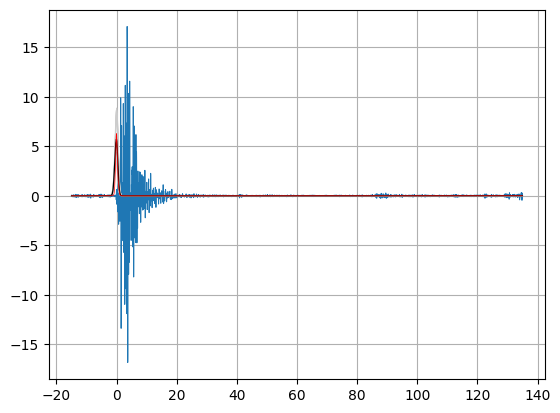

3117053 2020-03-09T16:42:30.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


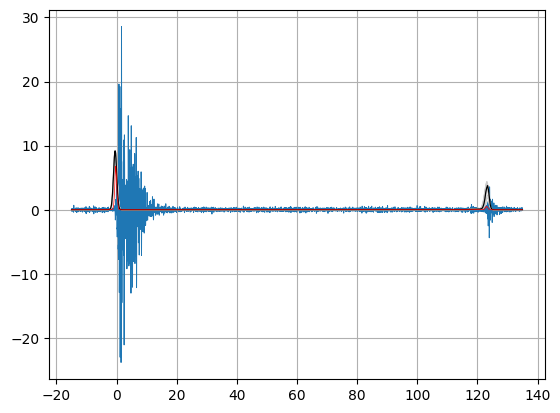

3117193 2020-03-09T21:31:29.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


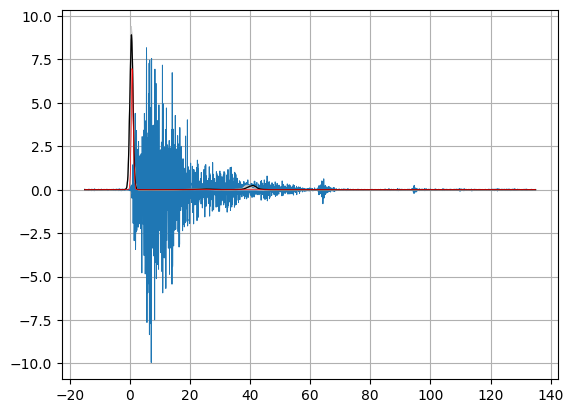

3117313 2020-03-10T12:05:56.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


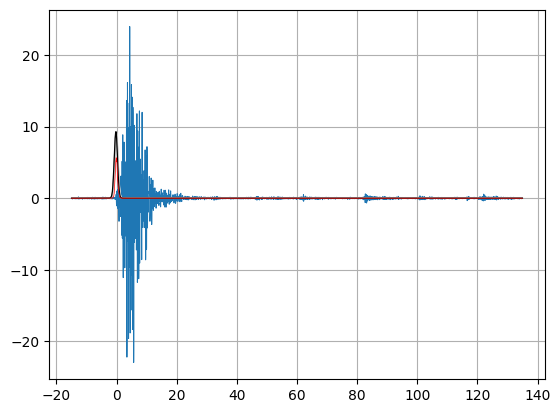

3117763 2020-03-12T09:27:57.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


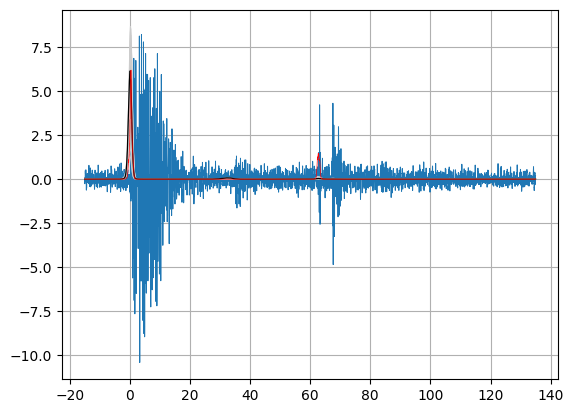

3118353 2020-03-13T04:59:36.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


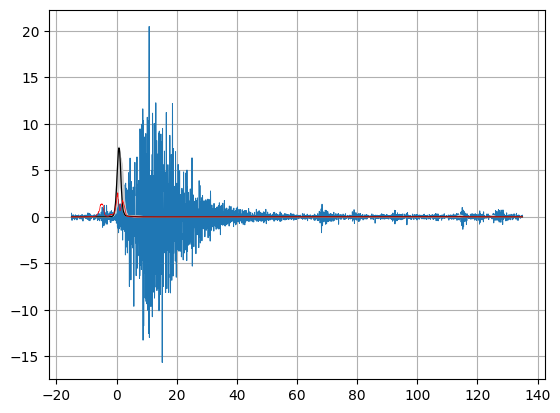

3118358 2020-03-13T07:48:31.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


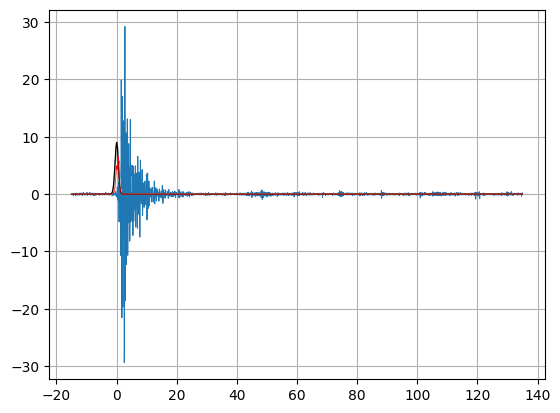

3118363 2020-03-13T11:48:04.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


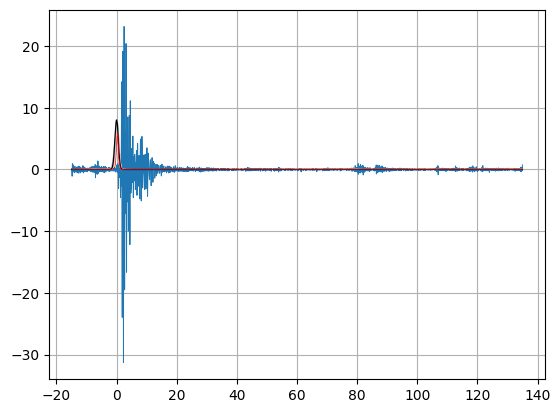

3118368 2020-03-13T13:27:12.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


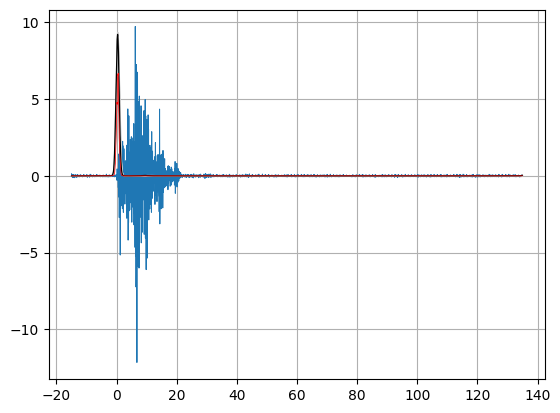

3118373 2020-03-13T13:41:55.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


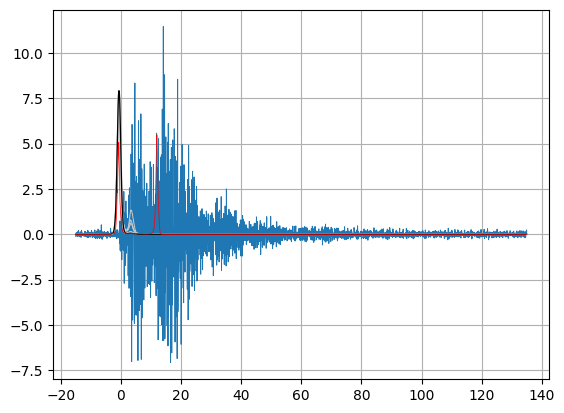

3117968 2020-03-13T20:59:08.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


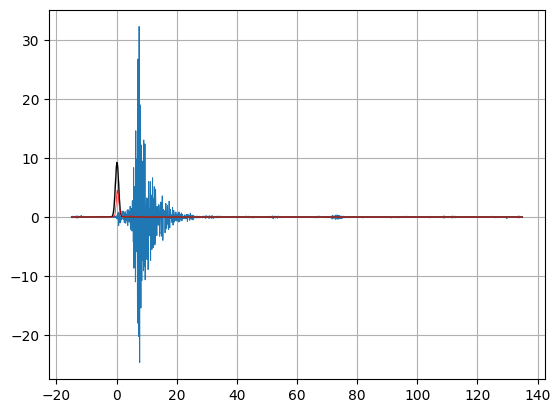

3117958 2020-03-14T00:52:29.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


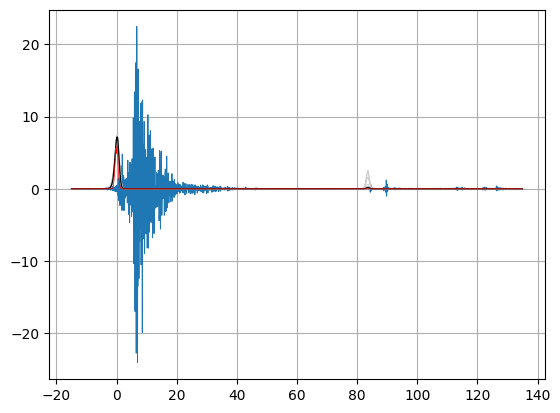

3118048 2020-03-14T03:43:26.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


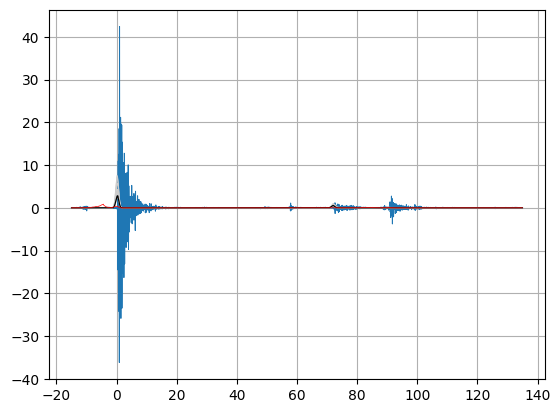

3118048 2020-03-14T03:43:27.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


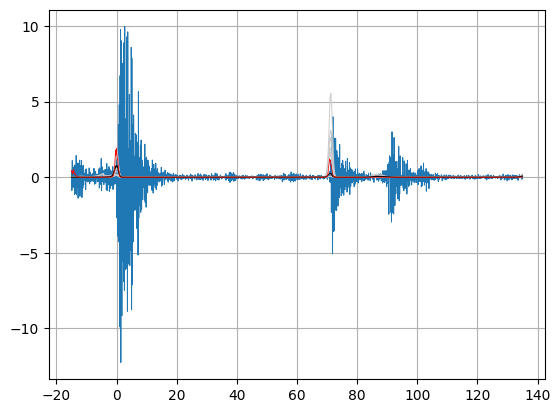

3118048 2020-03-14T03:43:28.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


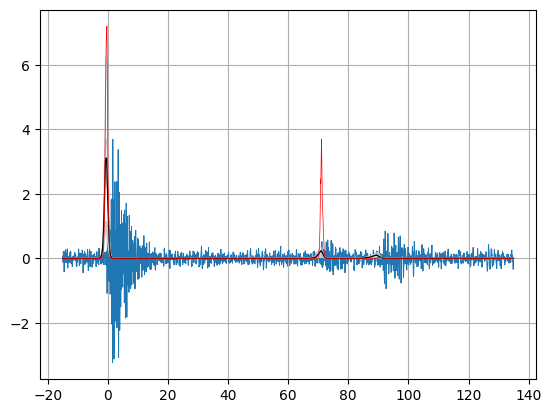

3118048 2020-03-14T03:43:28.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


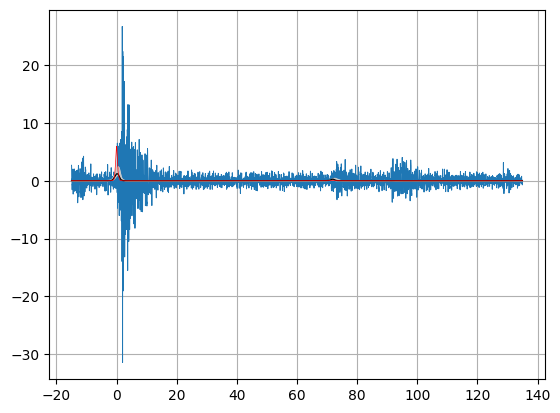

3118048 2020-03-14T03:43:30.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


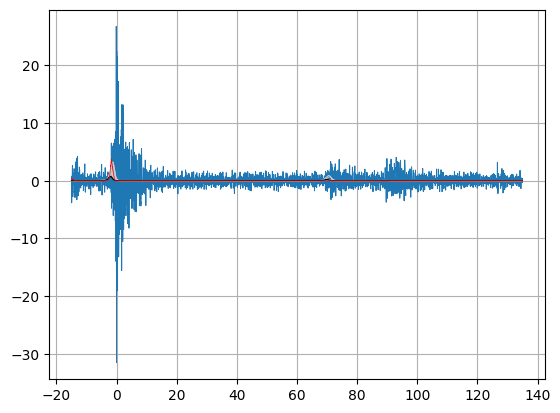

3119028 2020-03-14T05:54:21.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


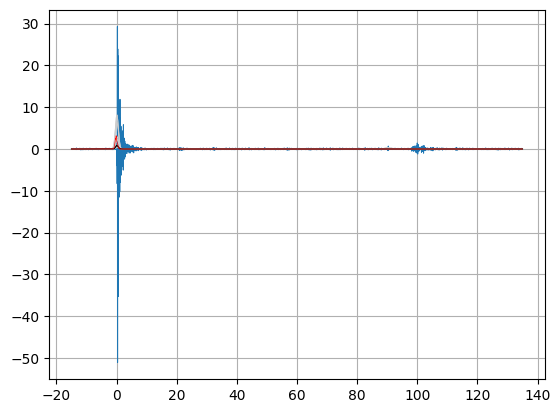

3119028 2020-03-14T05:54:22.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


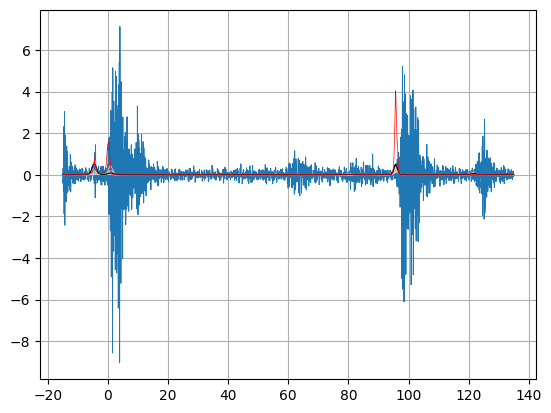

3119028 2020-03-14T05:54:23.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


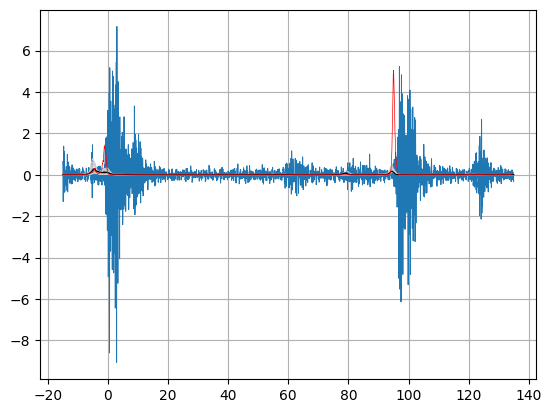

3119038 2020-03-14T06:00:44.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


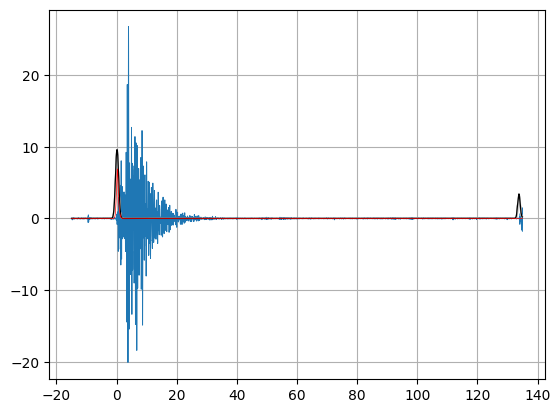

3118138 2020-03-15T23:52:19.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


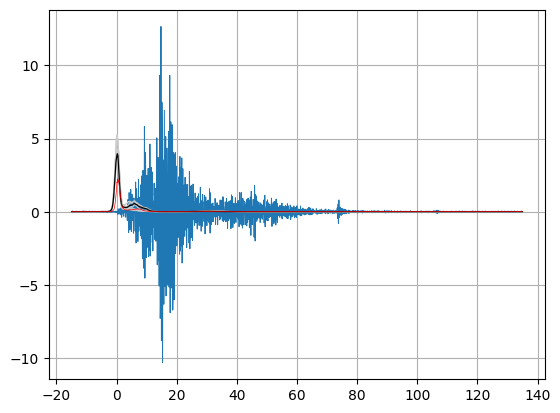

3118133 2020-03-16T07:08:48.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


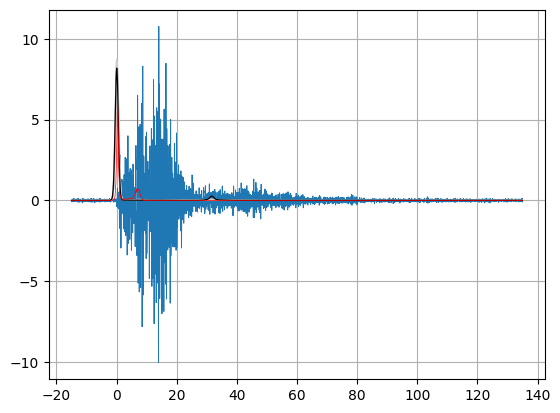

3118118 2020-03-16T15:34:30.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


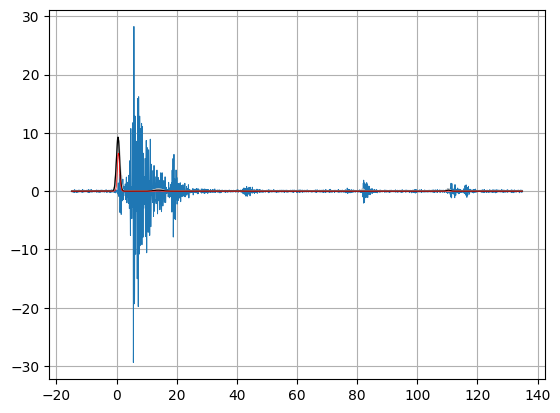

3118318 2020-03-16T23:08:31.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


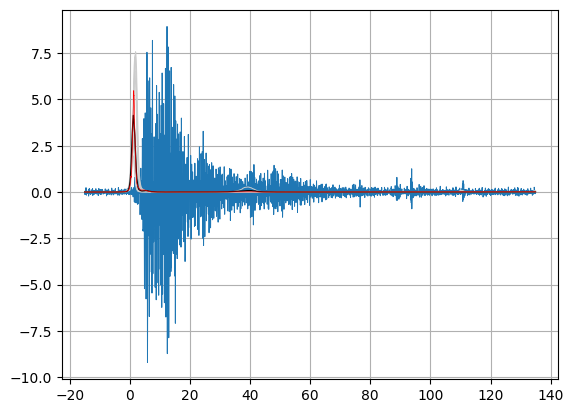

3119988 2020-03-17T01:29:20.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


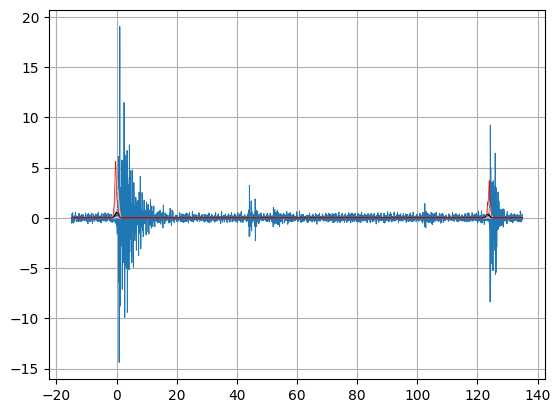

3119988 2020-03-17T01:29:20.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


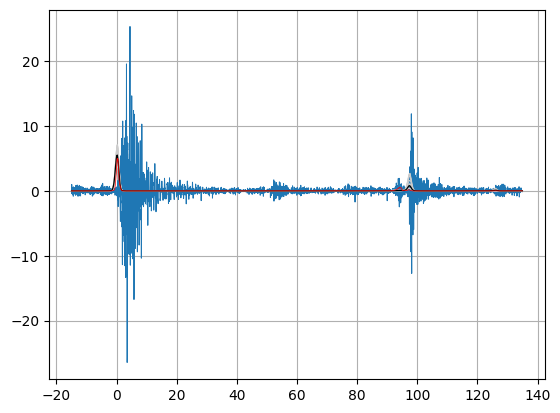

3119988 2020-03-17T01:29:21.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


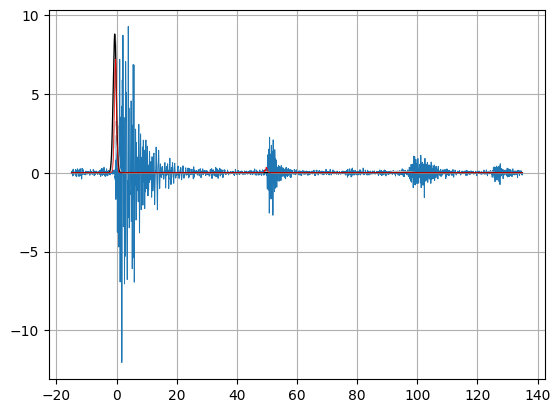

3119988 2020-03-17T01:29:21.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


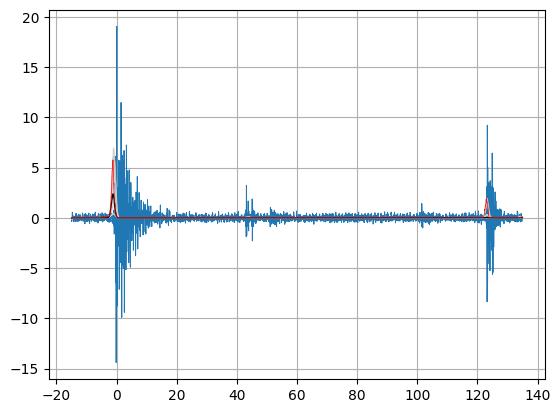

3119988 2020-03-17T01:29:21.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


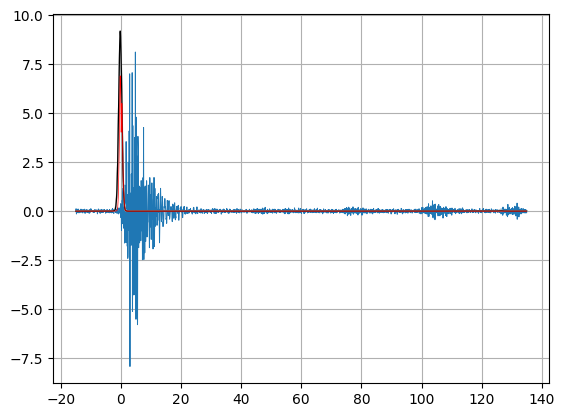

3119988 2020-03-17T01:29:21.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


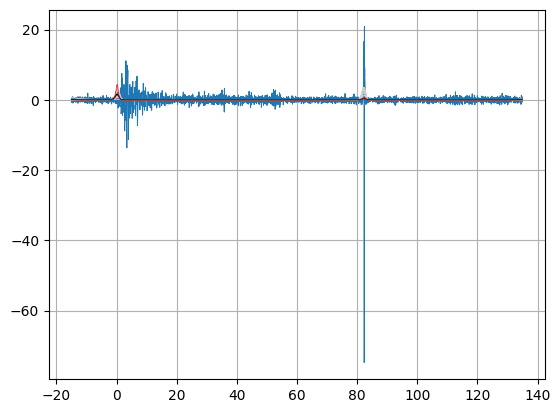

3119993 2020-03-17T02:02:14.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


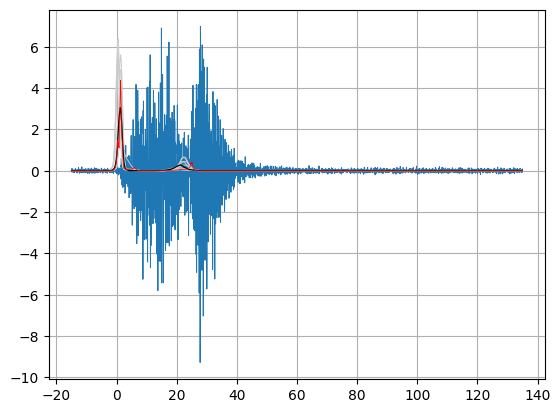

3120018 2020-03-17T07:13:28.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


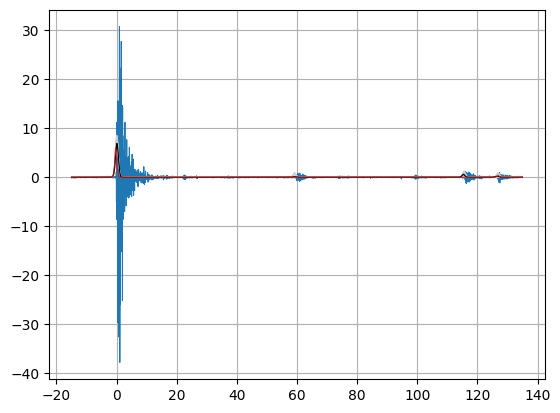

3118283 2020-03-17T12:55:09.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


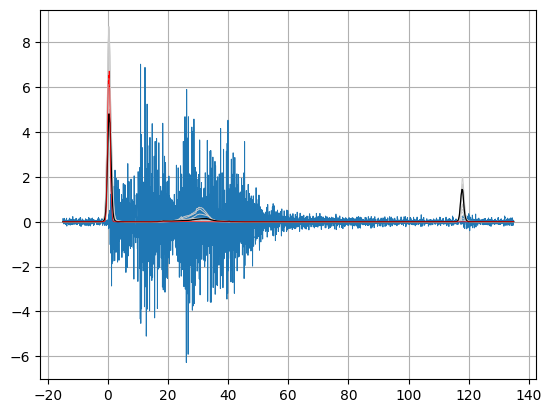

3118433 2020-03-18T06:53:23.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


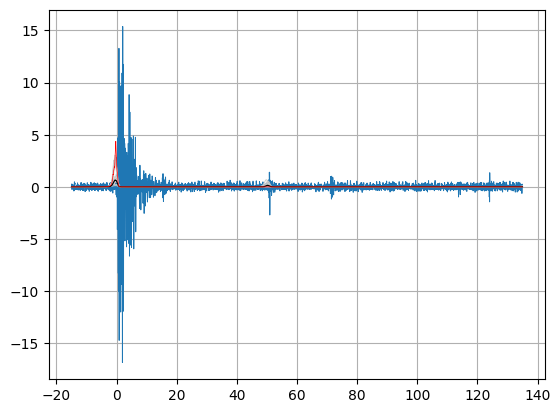

3118433 2020-03-18T06:53:23.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


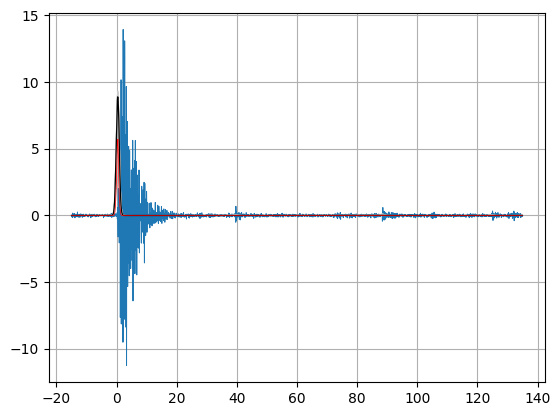

3118433 2020-03-18T06:53:23.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


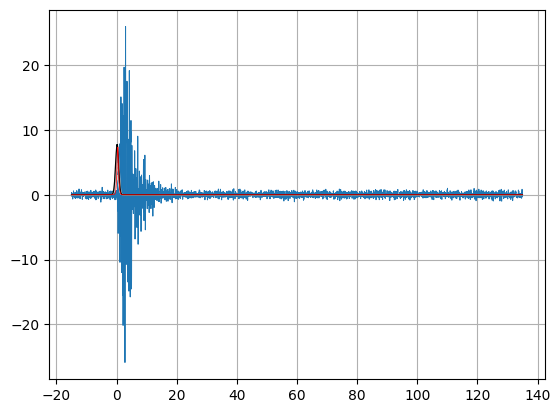

3118433 2020-03-18T06:53:24.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


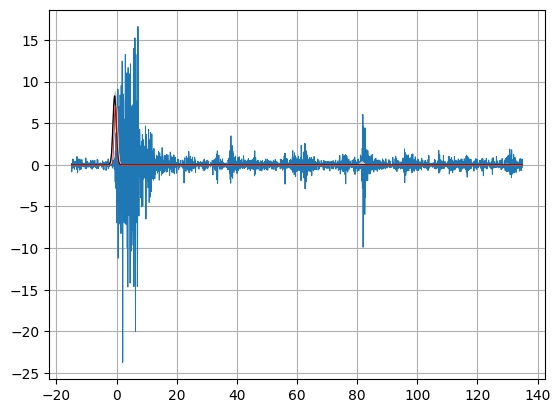

3118433 2020-03-18T06:53:24.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


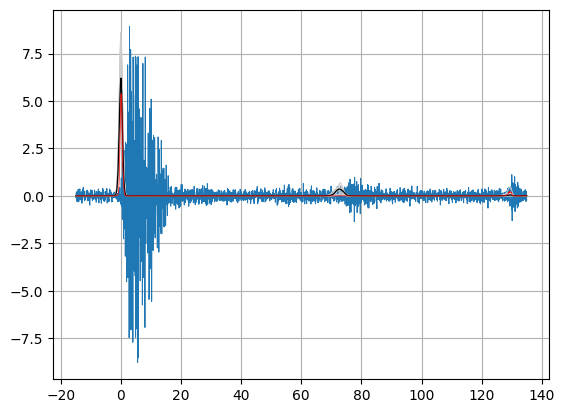

3118433 2020-03-18T06:53:26.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


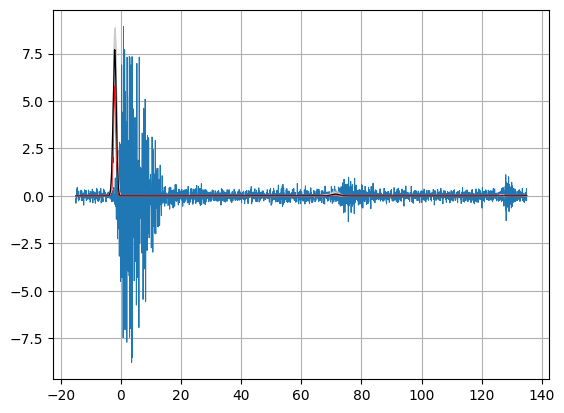

3118438 2020-03-18T07:59:27.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


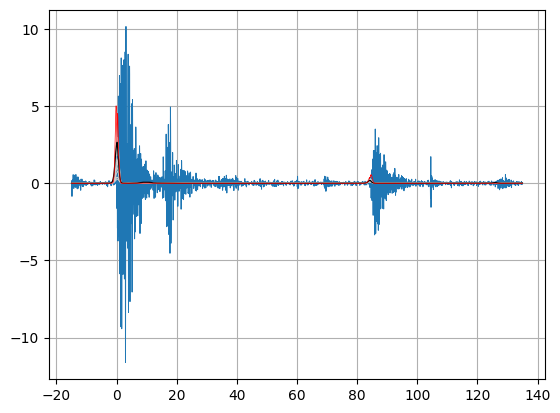

3121063 2020-03-18T08:24:23.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


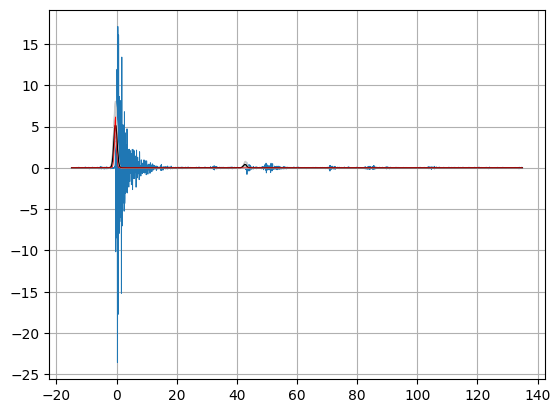

3121063 2020-03-18T08:24:23.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


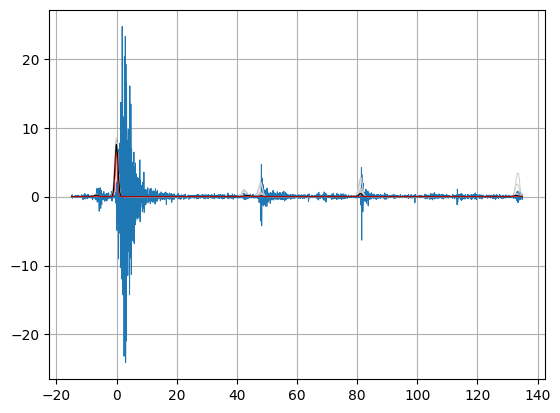

3121063 2020-03-18T08:24:24.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


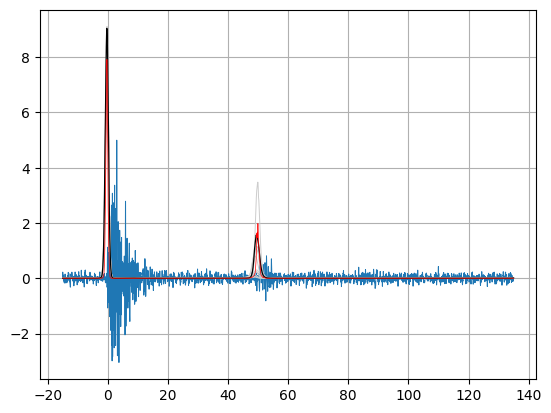

3121063 2020-03-18T08:24:24.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


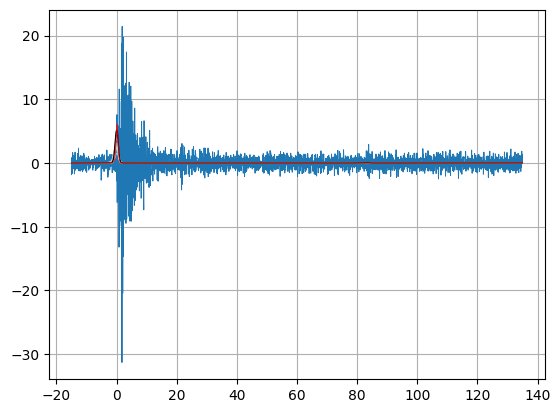

3121063 2020-03-18T08:24:24.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


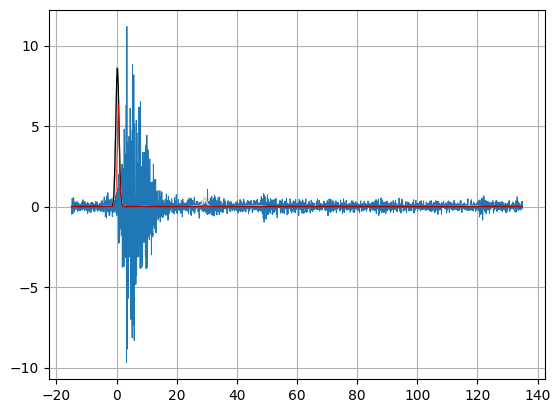

3118413 2020-03-18T12:37:39.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


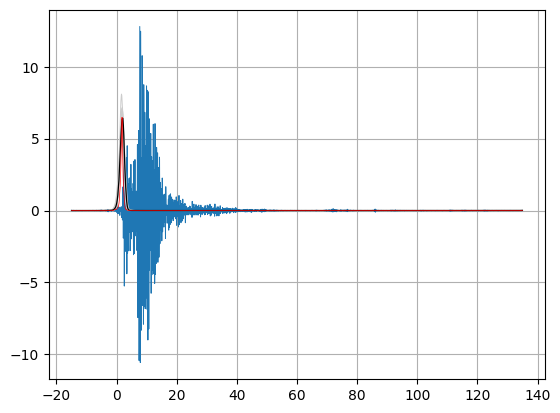

3118633 2020-03-19T08:06:52.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


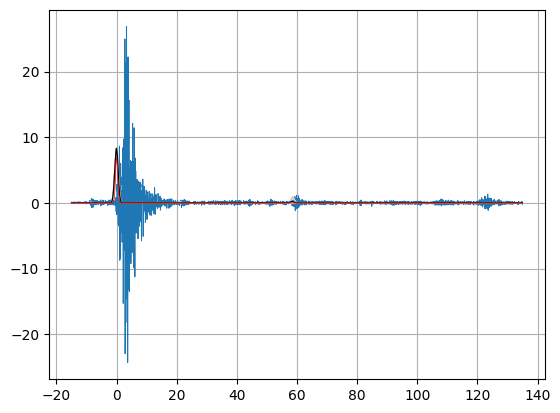

3118618 2020-03-19T09:13:06.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


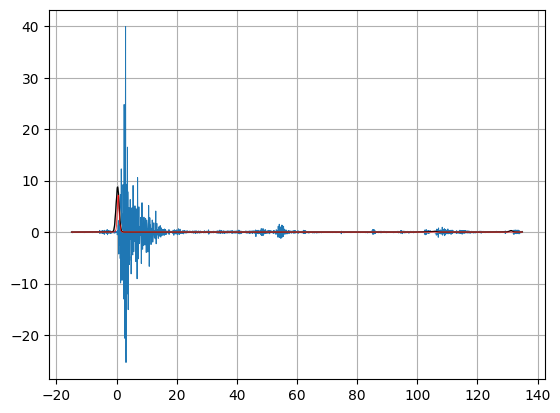

3118598 2020-03-19T12:46:39.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


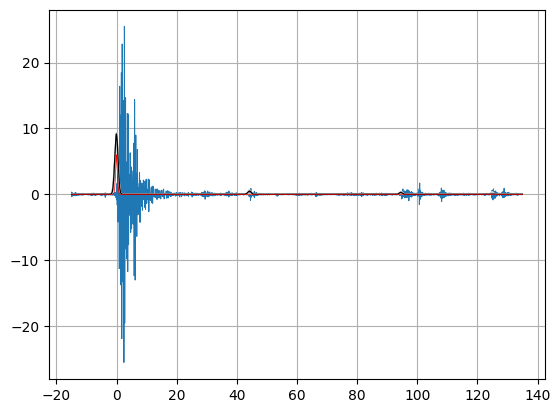

3118598 2020-03-19T12:46:39.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


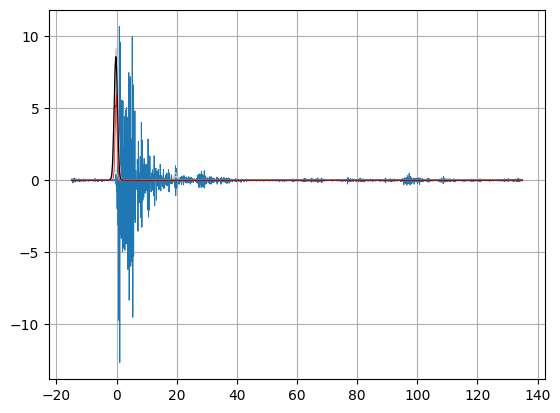

3118598 2020-03-19T12:46:39.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


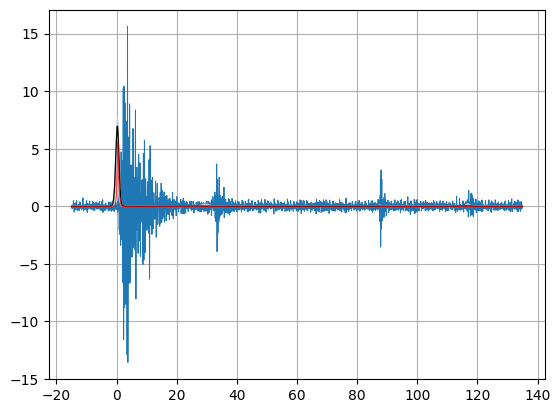

3118598 2020-03-19T12:46:40.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


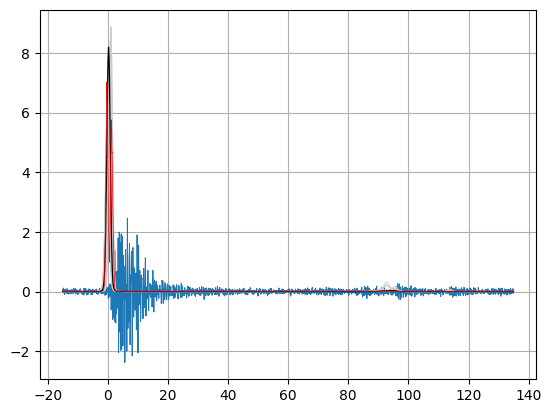

3118598 2020-03-19T12:46:40.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


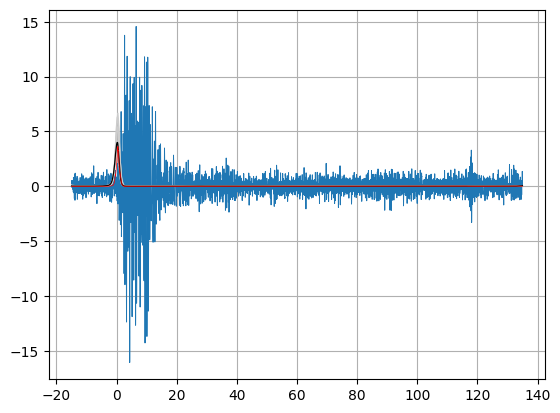

3118598 2020-03-19T12:46:41.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


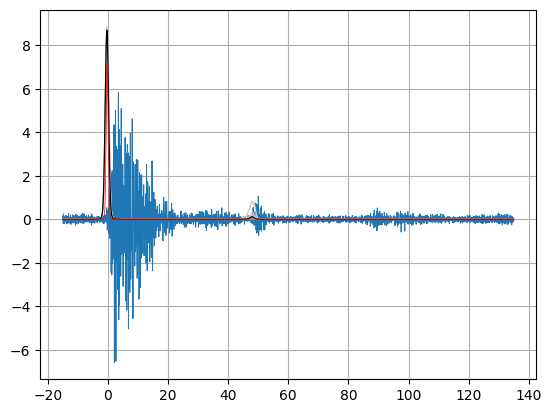

3118598 2020-03-19T12:46:42.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


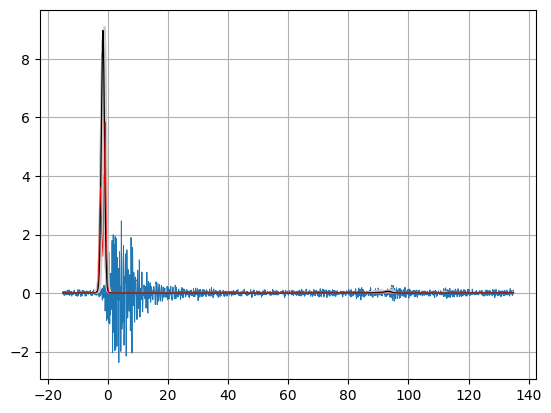

3121098 2020-03-20T00:39:16.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


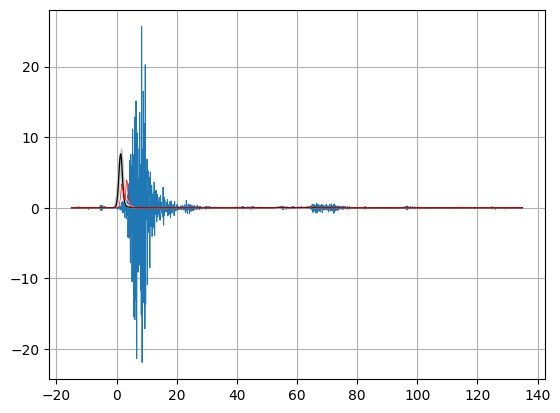

3118748 2020-03-20T10:20:51.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


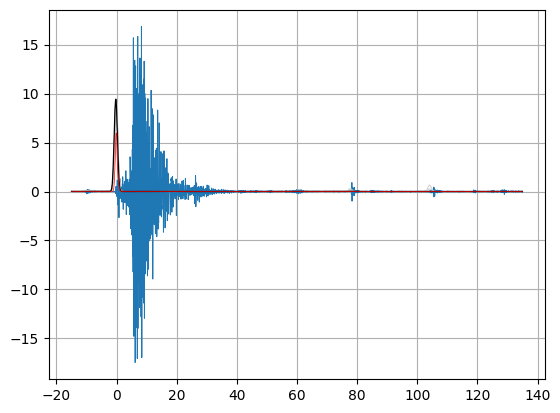

3119578 2020-03-21T06:57:46.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


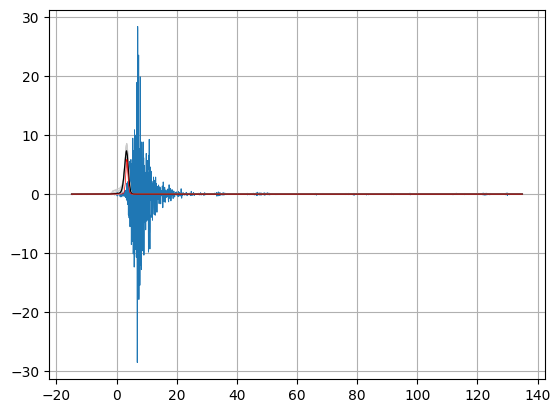

3118943 2020-03-21T17:59:40.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


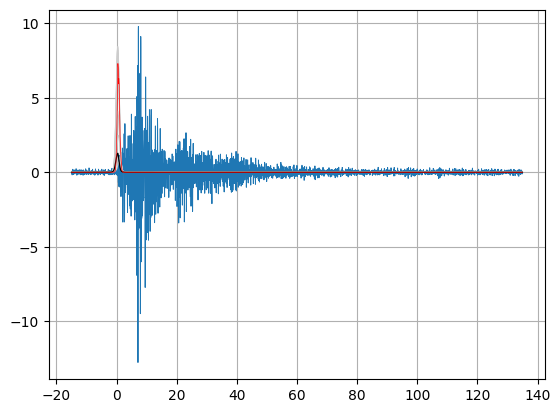

3118948 2020-03-21T23:23:40.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


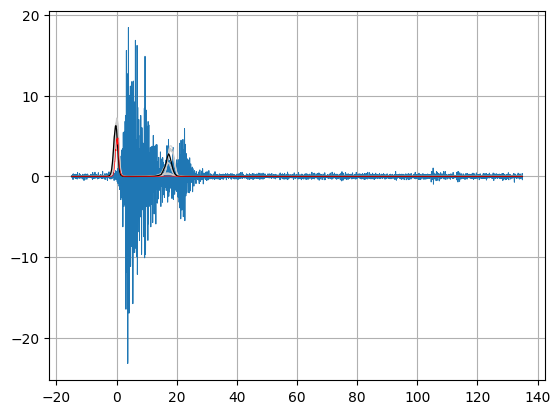

3118938 2020-03-22T07:22:18.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


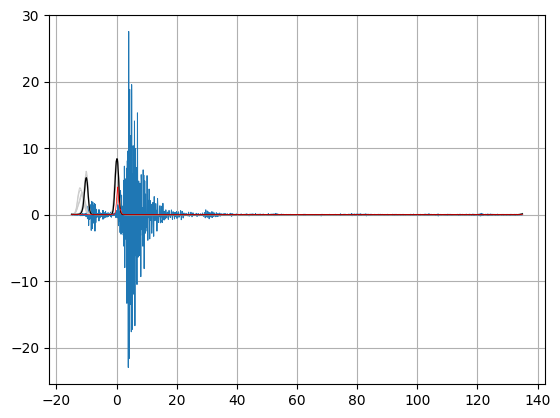

3119218 2020-03-25T10:36:57.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


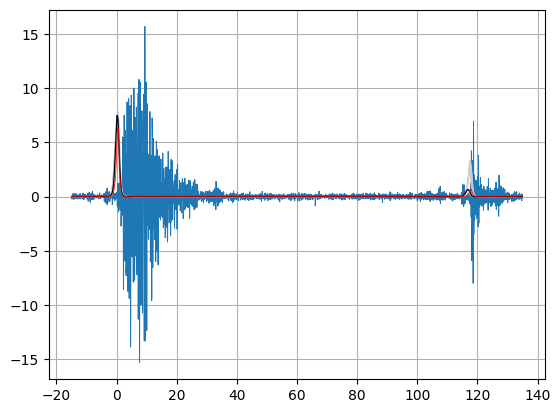

3119378 2020-03-26T00:57:16.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


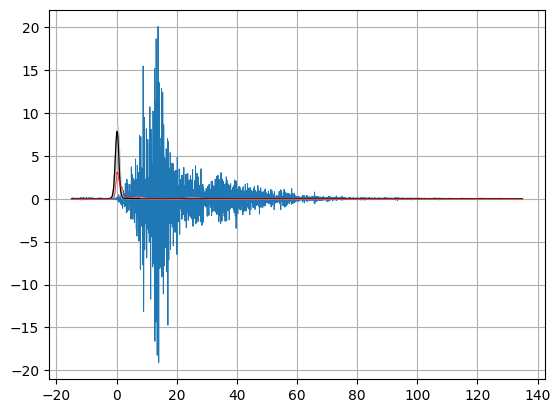

3119363 2020-03-26T06:51:09.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


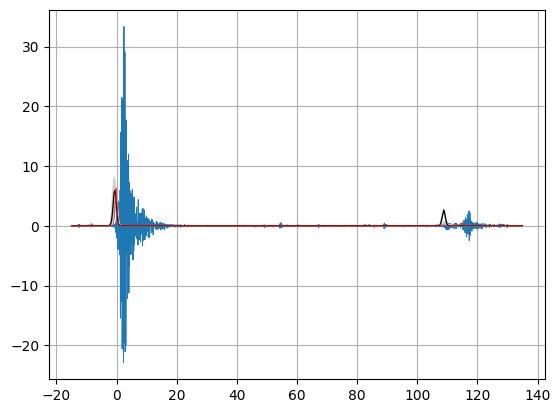

3119298 2020-03-26T11:09:08.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


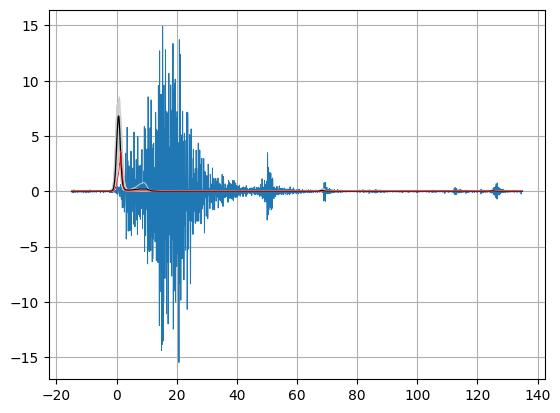

3119323 2020-03-26T16:13:56.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


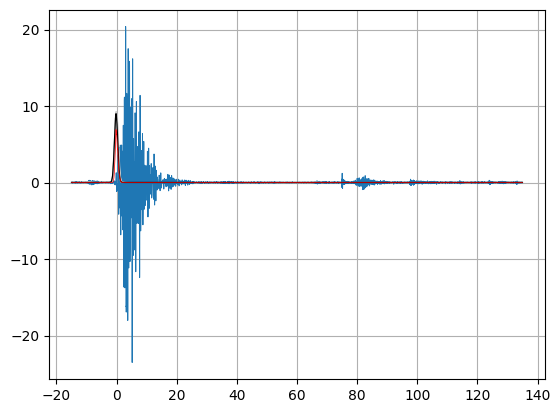

3119558 2020-03-26T22:44:27.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


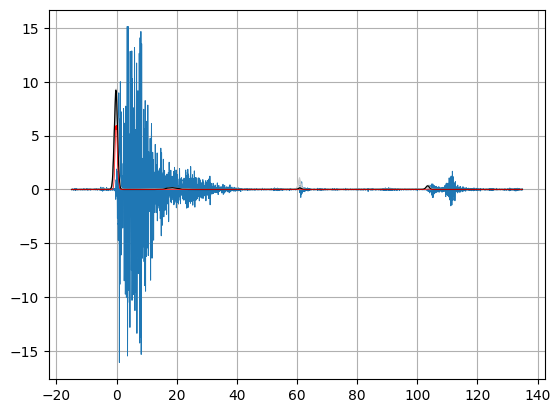

3119528 2020-03-27T09:43:42.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


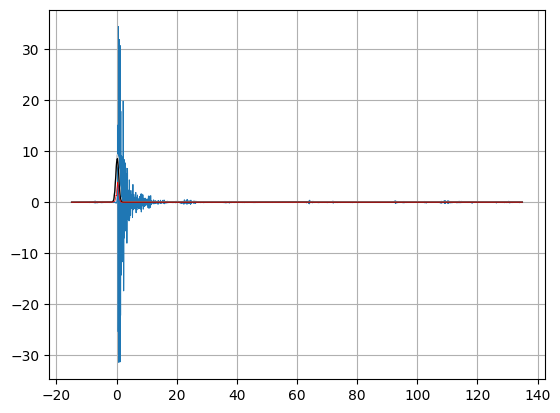

3119528 2020-03-27T09:43:43.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


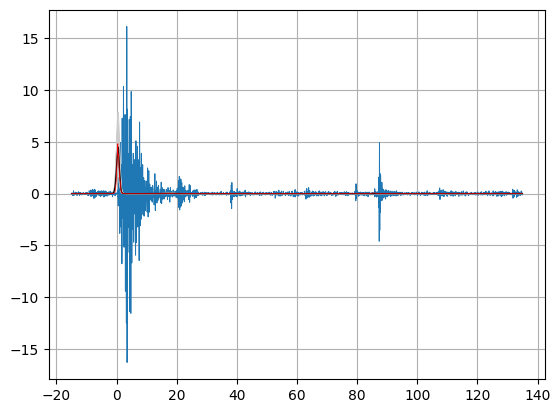

3119528 2020-03-27T09:43:44.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


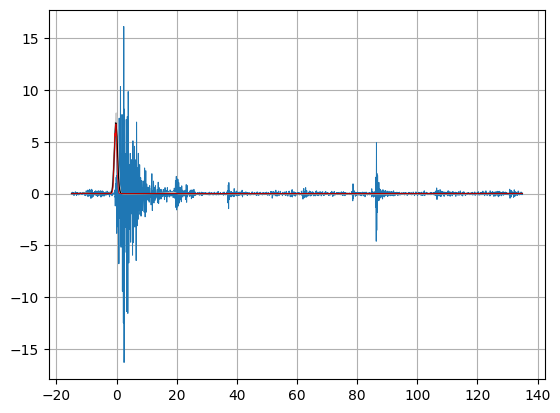

3119528 2020-03-27T09:43:44.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


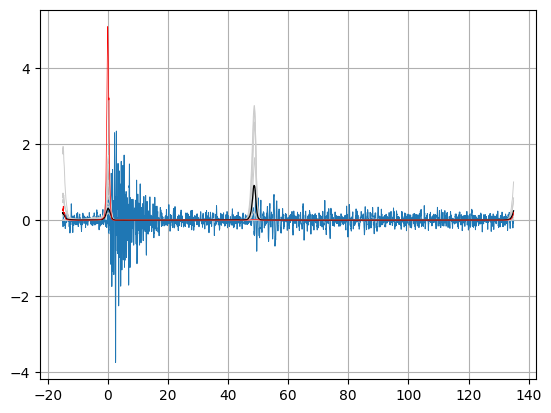

3119528 2020-03-27T09:43:44.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


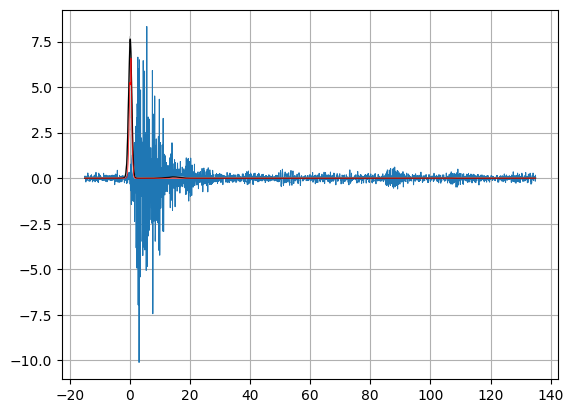

3119528 2020-03-27T09:43:45.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


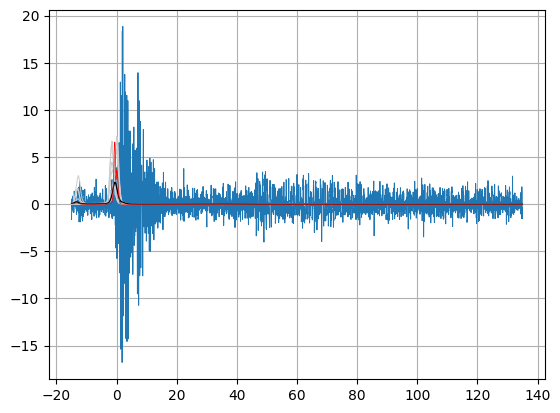

3119528 2020-03-27T09:43:45.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


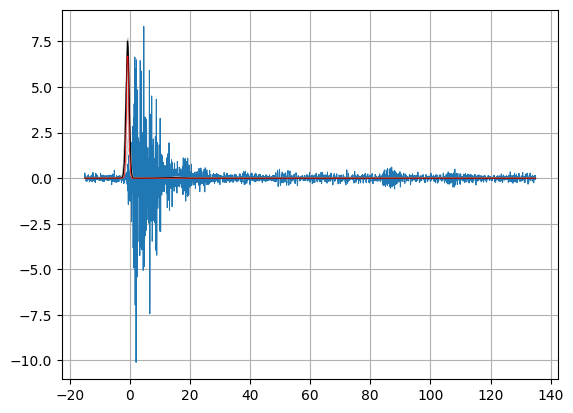

3121398 2020-03-30T00:05:39.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


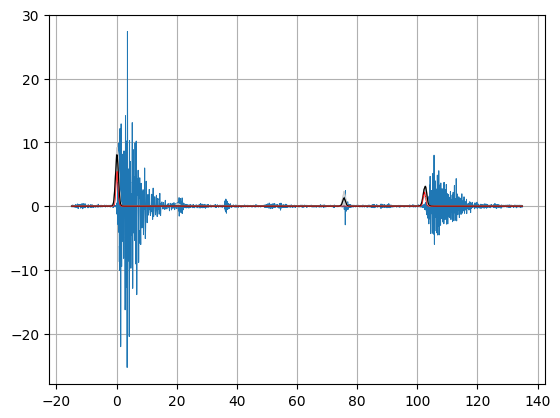

3119913 2020-03-30T20:09:25.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


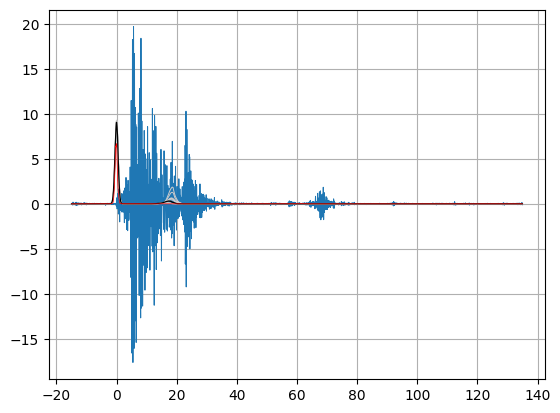

3119943 2020-03-31T04:47:32.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


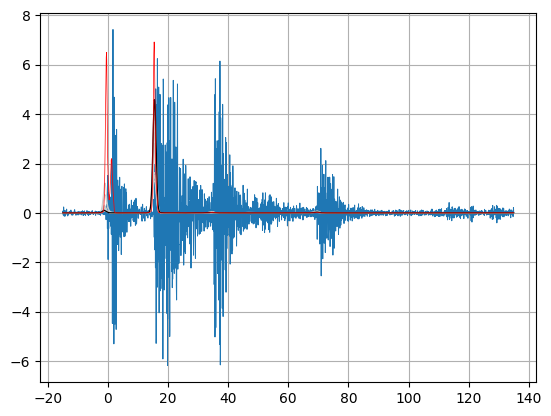

3119948 2020-03-31T06:43:00.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


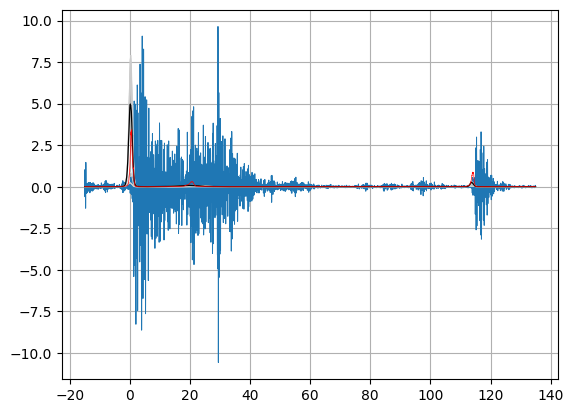

3119953 2020-03-31T13:28:12.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


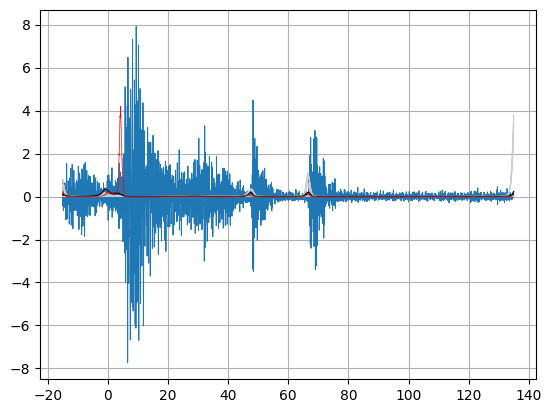

3120728 2020-04-01T23:44:22.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


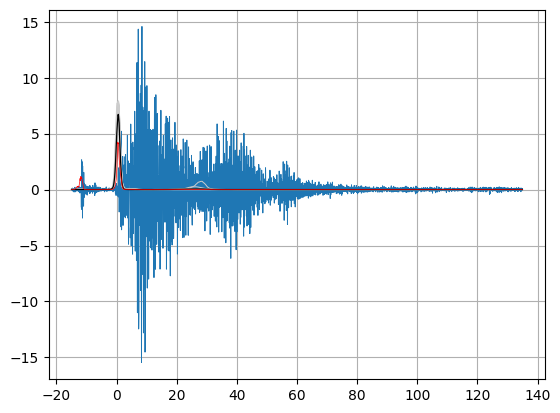

3120383 2020-04-02T05:20:25.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


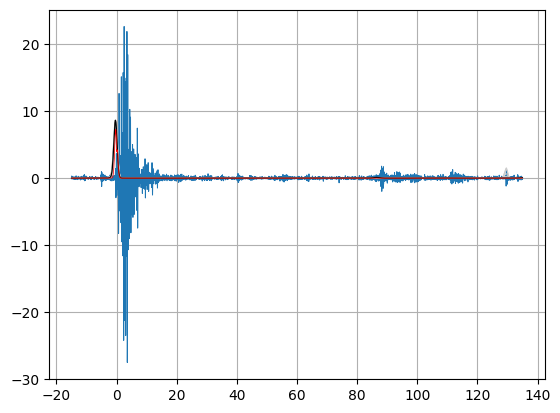

3120383 2020-04-02T05:20:25.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


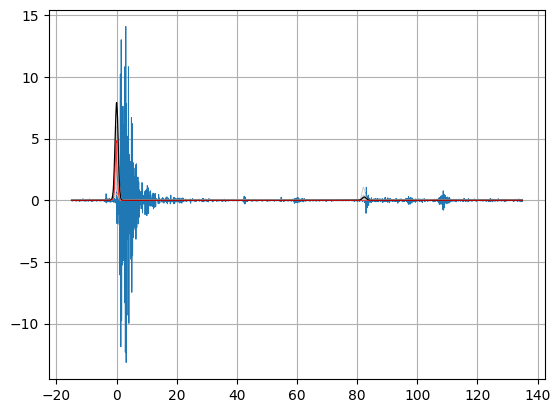

3120383 2020-04-02T05:20:25.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


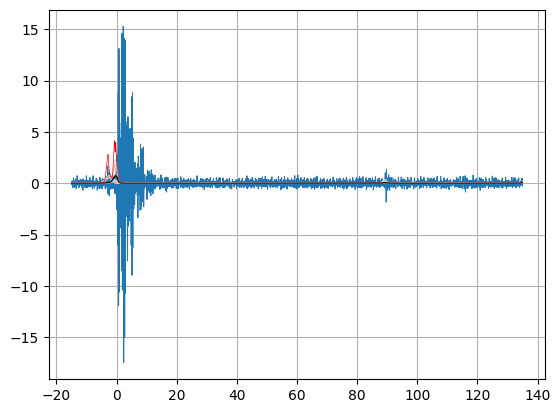

3120383 2020-04-02T05:20:26.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


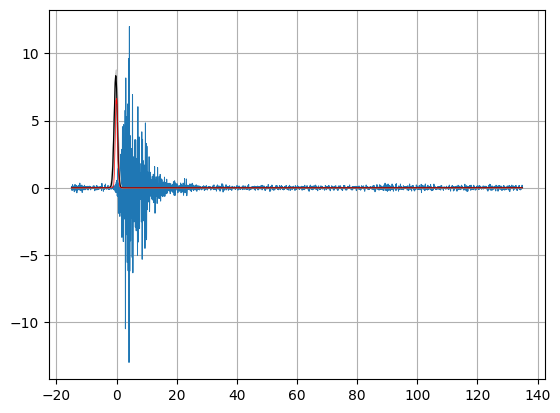

3120733 2020-04-02T21:44:10.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


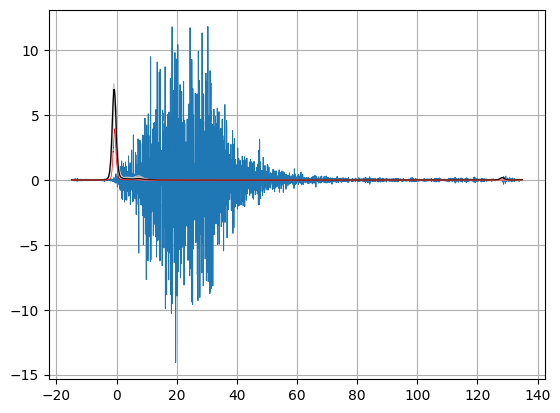

3120843 2020-04-03T02:42:59.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


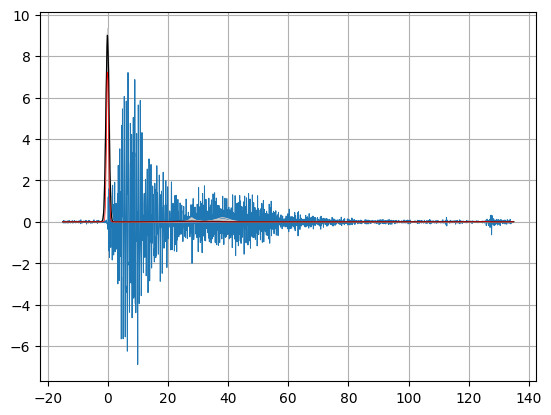

3120838 2020-04-03T03:15:48.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


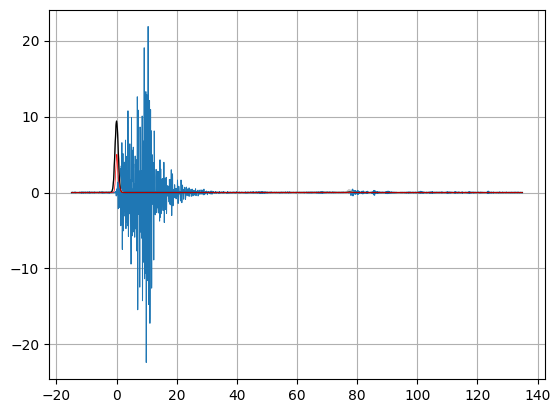

3122338 2020-04-03T13:00:37.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


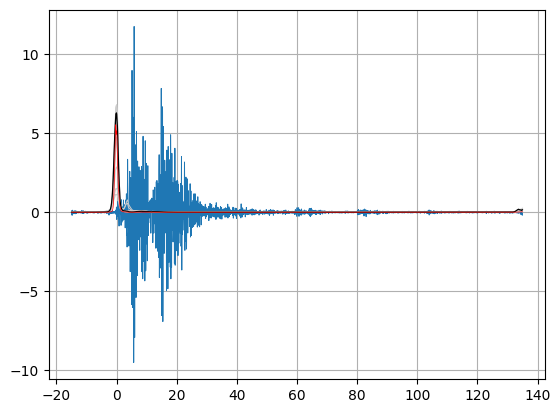

3121418 2020-04-04T20:09:01.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


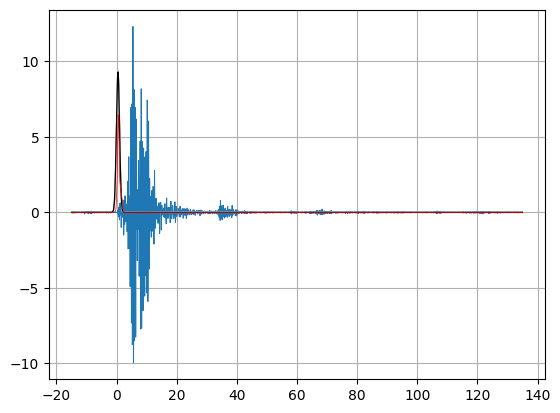

3121423 2020-04-05T04:17:17.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


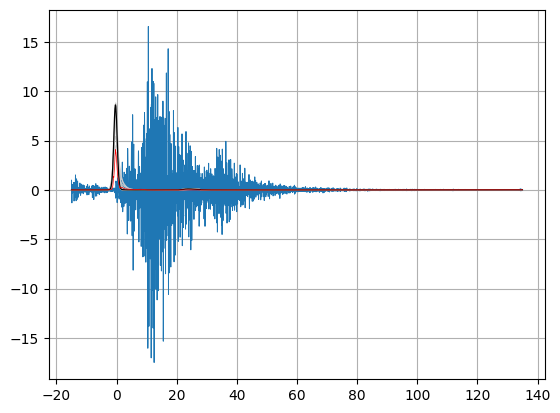

3121428 2020-04-05T05:02:15.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


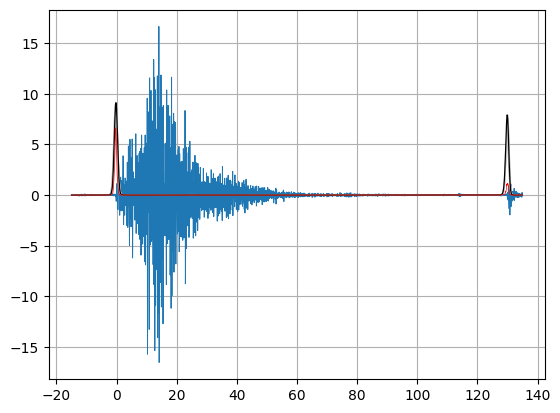

3121548 2020-04-05T15:01:48.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


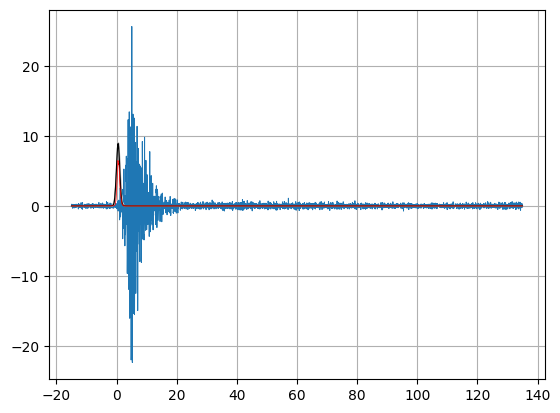

3121543 2020-04-05T16:18:07.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


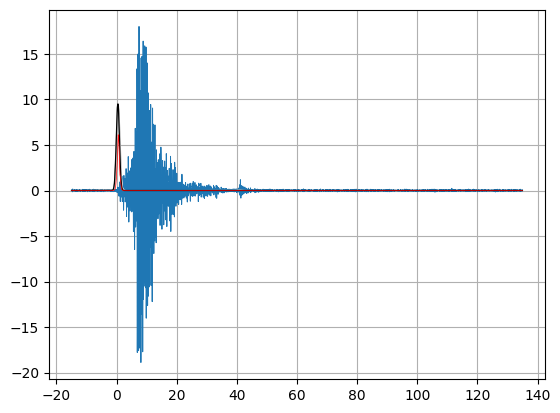

3121538 2020-04-05T18:58:53.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


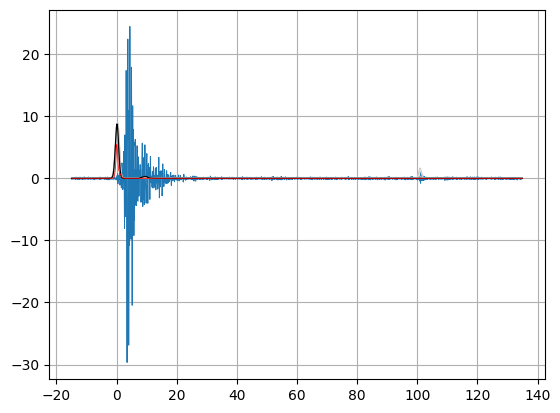

3123283 2020-04-06T07:38:35.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


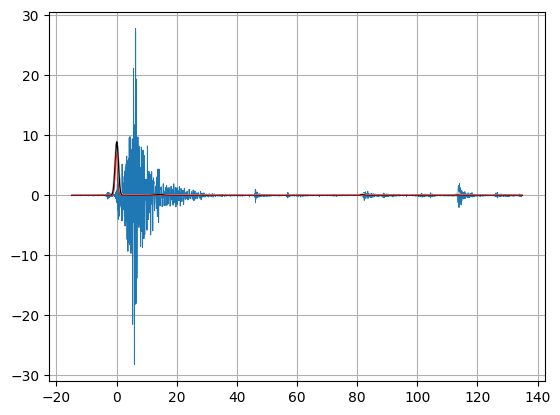

3121868 2020-04-06T14:19:47.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


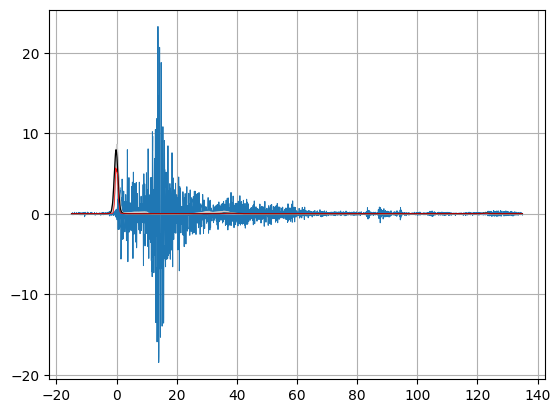

3121838 2020-04-07T00:32:21.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


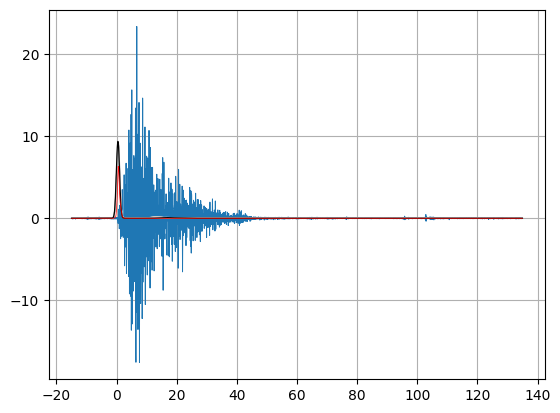

3122048 2020-04-07T19:31:52.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


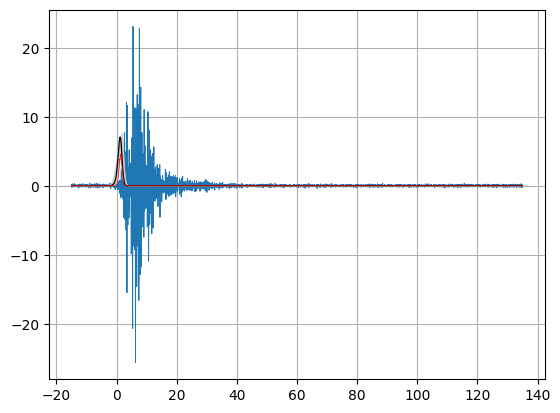

3122683 2020-04-09T13:28:42.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


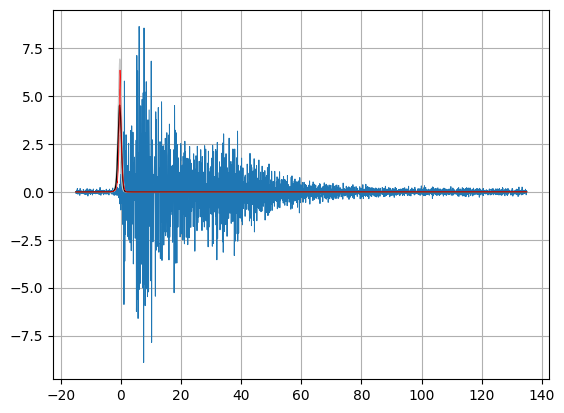

3122683 2020-04-09T13:28:42.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


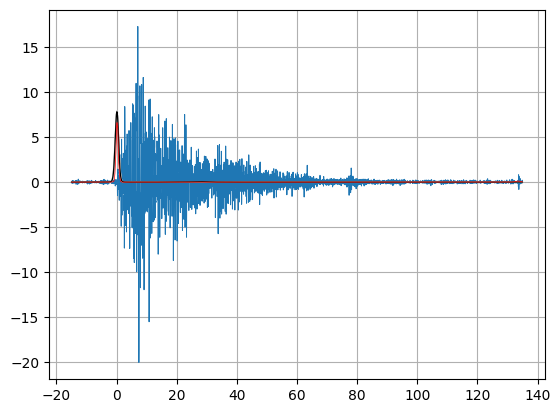

3122683 2020-04-09T13:28:43.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


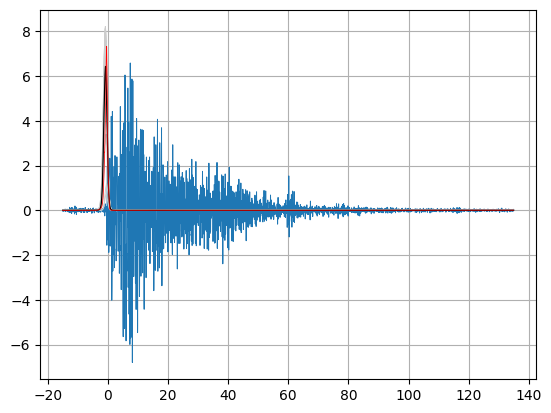

3122683 2020-04-09T13:28:43.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


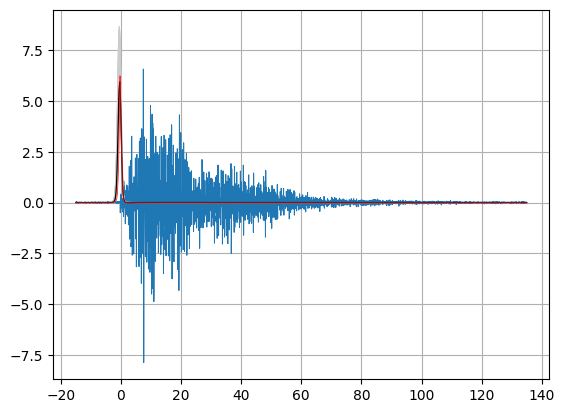

3122683 2020-04-09T13:28:43.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


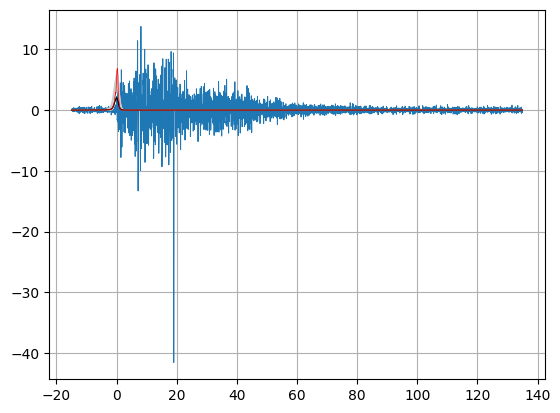

3122683 2020-04-09T13:28:44.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


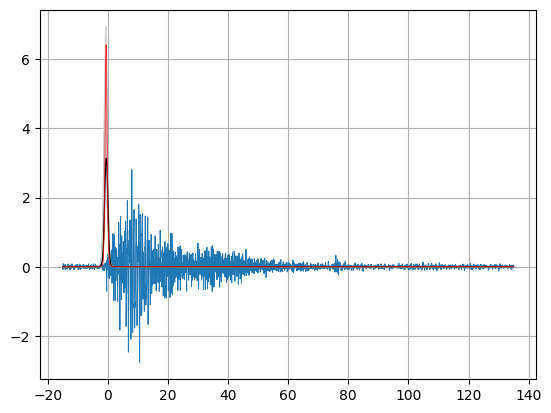

3122683 2020-04-09T13:28:44.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


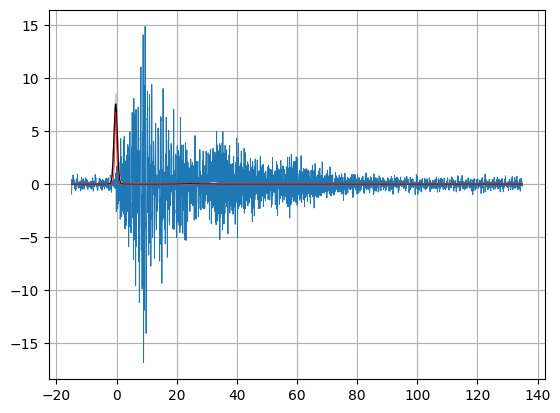

3122583 2020-04-10T01:32:06.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


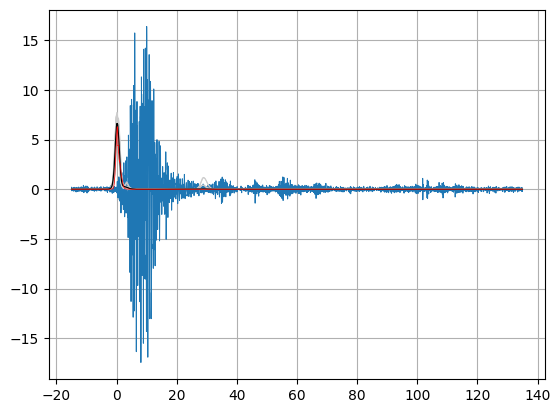

3122588 2020-04-10T03:01:57.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


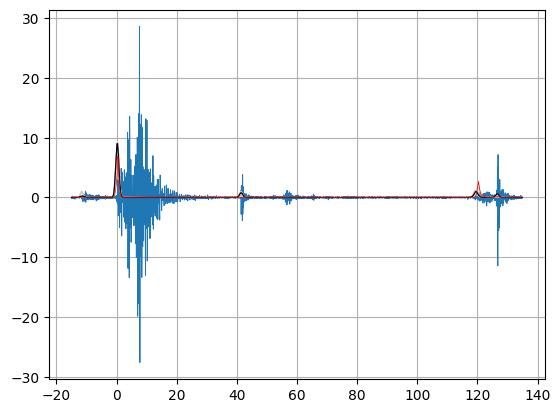

3123798 2020-04-11T18:59:29.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


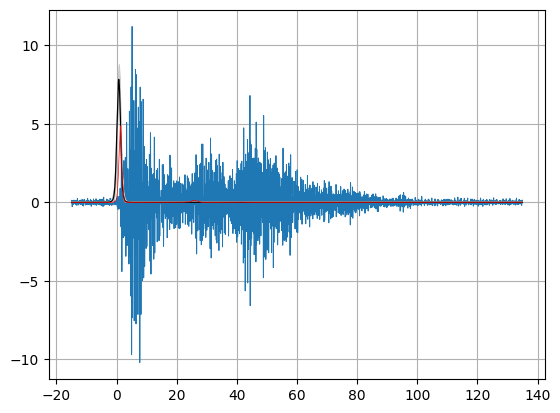

3123983 2020-04-12T16:11:42.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


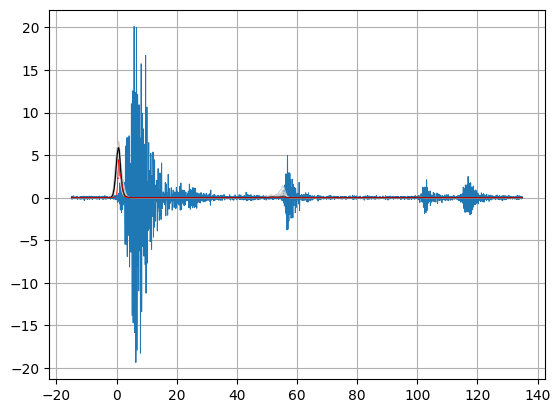

3122913 2020-04-13T09:01:12.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


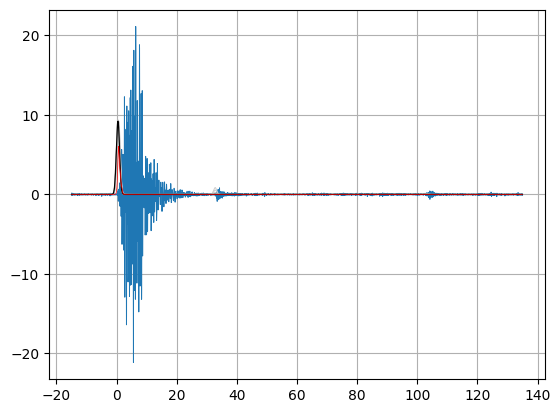

3122908 2020-04-13T10:23:19.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB
Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


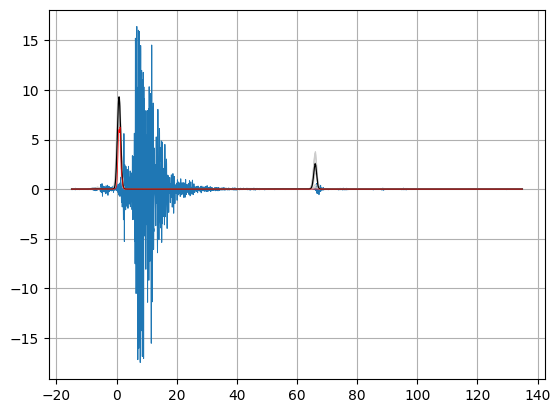

3123138 2020-04-14T02:15:40.000000Z
Mt_Rainier
put data in numpy array
There are 1 stations available
now predicting on BB


/var/folders/j4/3rbzxjb16kv66g_p4wkzq16h0000gn/T/ipykernel_54365/1065548624.py:121: RuntimeWarning: invalid value encountered in divide
  data_std = crap2 / np.std(crap2) + 1e-10


Shape of the multi-band data array:  (1, 10, 3, 6000)
now predicting on MBF


/var/folders/j4/3rbzxjb16kv66g_p4wkzq16h0000gn/T/ipykernel_54365/1065548624.py:164: RuntimeWarning: invalid value encountered in divide
  windows_std[ista, ifreq,:, :] = _windows_mb[ista, ifreq, :]  \


ValueError: x and y must have same first dimension, but have shapes (2471,) and (6000,)

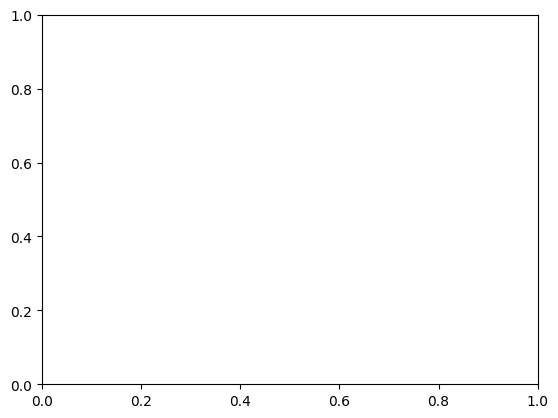

In [26]:
pick_error = np.zeros(len(evt_id))
from matplotlib.backends.backend_pdf import PdfPages
pdf = PdfPages('../plots/MLPicks_MB_test.pdf')
for n in range(len(evt_id)): 
    if start_time[n]<datetime(2020,1,1):continue   
    event_ID = str(evt_id[n])
    otime = UTCDateTime(start_time[n])
    networks=net[n]
    stations=sta[n]
    if sta[n]=="LON" or sta[n]=="LO2":continue
    # print(net[n],sta[n])
    try:
        associated_volcano = df[df['Station']== sta[n]]['Volcano_Name'].values[0]
    except: 
        pass
    if associated_volcano!="Mt_Rainier":continue
            
#################### WAVEFORM DOWNLOAD #######################
    #Download all waveforms for that event based on stations and times
    bulk=[[net[n], sta[n], '*', '*H*', otime-t_before_raw, otime+t_before_raw]]
    # try:
    st = client2.get_waveforms_bulk(bulk)
    st = resample(st,fs)  #resampling the data to 40Hz for each trace
    
    evt_data = obspy.Stream()

    # #Plotting all traces for one event with channel z, SNR>10, and bandpasses between 2-12Hz
    SNR,SNR_weight, no_weight,stas,nets,max_amp_times,durations,data_env_dict,t_diff = [],[],[],[],[],[],[],{},{}
    for i,ii in enumerate(st):
        network = ii.stats.network
        station = ii.stats.station
        ii.detrend(type = 'demean')
        ii.filter('bandpass',freqmin=low_cut,freqmax=high_cut,corners=2,zerophase=True)
        cha = ii.stats.channel
        starttime = ii.stats.starttime
        signal_window = ii.copy()
        noise_window = ii.copy()
        # trim the data and noise window to exactly 6000 points
        signal_window.trim(otime - t_before, otime - t_before + window) # trim the signal at the first pick time of the PNSN data, with loose 40s before
        noise_window.trim(otime - window -t_before, otime - t_before) # noise window of the same length
        if not len(signal_window.data) or not len(signal_window.data): continue
        # print(len(signal_window),len(noise_window.data))
        if not np.max(np.percentile(np.abs(signal_window.data),pr)):continue
        if len(noise_window.data)==0:continue
        snr = (20 * np.log(np.percentile(np.abs(signal_window.data),pr) 
                        / np.percentile(np.abs(noise_window.data),pr))/np.log(10))
        max_amp_time = np.argmax(noise_window.data)/fs
        # print(snr,max_amp_time)
        # signal_window.plot()x
        if snr<thr: 
            st.remove(ii)
            continue
        # start the time axis 15 seconds before the pick time of the first reference station
        t = signal_window.times()[:-1] #
        t_diff[network+'.'+station] = starttime-otime 
        stas.append(ii.stats.station)
        nets.append(ii.stats.network)
        SNR.append(snr)
        SNR_weight.append(int(snr))
        no_weight.append(1)
        evt_data.append(signal_window)
        
    sta_available,ind = np.unique(np.array(stas),return_index=True)
    sta_available=sta_available[np.argsort(ind)]
    if len(sta_available)==0:continue

    print(event_ID,otime)
    print(associated_volcano)
    bigS = np.zeros(shape=(len(sta_available),3,6000))
    stas=[]
    # print(sta_available)
    # print(evt_data)
    for i in range(len(sta_available)):
        stream = evt_data.select(station=sta_available[i])
        # print(i,stream)
        if len(stream[0].data)<6000:continue
        # print("original stream")
        # print(stream)
        if len(stream)<3:
            # copy stream to 2 components, zero the missing data.
            tr3 = stream[0].copy() # assumed to be the vertical
            tr2 = stream[0].copy();tr2.stats.channel=stream[0].stats.channel[0:2]+"N"
            tr1 = stream[0].copy();tr1.stats.channel=stream[0].stats.channel[0:2]+"E"
            tr1.data=np.zeros(len(stream[0].data))
            tr2.data=np.zeros(len(stream[0].data))
            stream=obspy.Stream(traces=[tr1,tr2,tr3])
        # convert Stream into seisbench-friendly array    
        # fill in big array and order data ZNE
        bigS[i,0,:]=stream[2].data[:-1]
        bigS[i,1,:]=stream[1].data[:-1]
        bigS[i,2,:]=stream[0].data[:-1]
        stas.append(sta_available[i])


    
    print("put data in numpy array")

    nwin,twin=bigS.shape[1],bigS.shape[-1]
    nsta = len(sta_available)
    print("There are %i stations available"%nsta)

    # allocating memory for the ensemble predictions
    # 7 pre-trained models, nsta stations for batch, 6000 input points
    batch_pred =np.zeros(shape=(7,nsta,6000)) 
    batch_pred_mbf =np.zeros(shape=(7,nsta,6000))


    # evaluate
    pn_pnw_model.eval()
    pn_ethz_model.eval()
    pn_scedc_model.eval()
    pn_neic_model.eval()
    pn_geofon_model.eval()
    pn_stead_model.eval()
    pn_instance_model.eval()

    ######### Broadband workflow ################
    crap2  = bigS.copy()
    crap2 -= np.mean(crap2,axis=-1,keepdims=True) # demean data
    # original use std norm
    data_std = crap2 / np.std(crap2) + 1e-10
    # could use max data
    mmax= np.max(np.abs(crap2), axis=-1, keepdims=True)
    data_max = np.divide(crap2 ,mmax,out=np.zeros_like(crap2),where=mmax!=0)
    data_tt = torch.Tensor(data_max)
    # batch predict picks.
    _torch_pred_1 = pn_pnw_model(data_tt.to(device))
    _torch_pred_2 = pn_ethz_model(data_tt.to(device))
    _torch_pred_3 = pn_scedc_model(data_tt.to(device))
    _torch_pred_4 = pn_neic_model(data_tt.to(device))
    _torch_pred_5 = pn_geofon_model(data_tt.to(device))
    _torch_pred_6 = pn_stead_model(data_tt.to(device))
    _torch_pred_7 = pn_instance_model(data_tt.to(device))
    # extract P pdf

    print("now predicting on BB")
    batch_pred[0,:, :] = _torch_pred_1[1].detach().cpu().numpy()[:, :]
    batch_pred[1,:, :] = _torch_pred_2[1].detach().cpu().numpy()[:, :]
    batch_pred[2,:, :] = _torch_pred_3[1].detach().cpu().numpy()[:, :]
    batch_pred[3,:, :] = _torch_pred_4[1].detach().cpu().numpy()[:, :]
    batch_pred[4,:, :] = _torch_pred_5[1].detach().cpu().numpy()[:, :]
    batch_pred[5,:, :] = _torch_pred_6[1].detach().cpu().numpy()[:, :]
    batch_pred[6,:, :] = _torch_pred_7[1].detach().cpu().numpy()[:, :]

    


    ############# Multi-band Workflow ########
    windows_std = np.zeros(shape=(nsta, nfqs, 3, twin), dtype= np.float32)
    windows_max = np.zeros(shape=( nsta, nfqs, 3, twin), dtype= np.float32)
    _windows = bigS.copy();#np.zeros(shape=(nsta, 3, twin), dtype= np.float32)
    _windows_mb = np.zeros(shape=(nsta, 3, nfqs, twin), dtype= np.float32)

    # MB filter
    for ista in range(nsta): # loop over stations, it should be one in this benchmark test
        for icha in range(3): # loop over channel, there should be 3 channels total
            _windows_mb[ista, icha, :, :] = MB_filter(_windows[ista, icha], MBF_paras)
    _windows_mb = _windows_mb.swapaxes(1, 2)
    print("Shape of the multi-band data array: ",_windows_mb.shape)
    # normalize the multi band data
    for ista in range(nsta):
        for ifreq in range(nfqs):
            # original use std norm
            windows_std[ista, ifreq,:, :] = _windows_mb[ista, ifreq, :]  \
                / np.std(_windows_mb[ista, ifreq, :]) + 1e-10
            # others use max norm
            mmax=np.max(np.abs(_windows_mb[ista, ifreq,:, :]), axis=-1, keepdims=True)
            windows_max[ista, ifreq,:, :] = np.divide(_windows_mb[ista, ifreq,:, :] \
                 ,mmax,out=np.zeros_like(_windows_mb[ista, ifreq, :]),where=mmax!=0)


    # print(f"Window data shape: {data_std.shape}"))


    print("now predicting on MBF")
    batch_pred_mbf_freq =np.zeros(shape=(7,nfqs,nsta,twin))
    for ifreq in range(nfqs):
        # convert numpy array to torch tensor
        data_tt_mbf = torch.Tensor(windows_max[:,ifreq,:,:])
        # batch predict picks.
        _torch_pred_1 = pn_pnw_model(data_tt_mbf.to(device))
        _torch_pred_2 = pn_ethz_model(data_tt_mbf.to(device))
        _torch_pred_3 = pn_scedc_model(data_tt_mbf.to(device))
        _torch_pred_4 = pn_neic_model(data_tt_mbf.to(device))
        _torch_pred_5 = pn_geofon_model(data_tt_mbf.to(device))
        _torch_pred_6 = pn_stead_model(data_tt_mbf.to(device))
        _torch_pred_7 = pn_instance_model(data_tt_mbf.to(device))
        # # extract P pdf
        batch_pred_mbf_freq[0,ifreq,:, :] = _torch_pred_1[1].detach().cpu().numpy()[:, :]
        batch_pred_mbf_freq[1,ifreq,:, :] = _torch_pred_2[1].detach().cpu().numpy()[:, :]
        batch_pred_mbf_freq[2,ifreq,:, :] = _torch_pred_3[1].detach().cpu().numpy()[:, :]
        batch_pred_mbf_freq[3,ifreq,:, :] = _torch_pred_4[1].detach().cpu().numpy()[:, :]
        batch_pred_mbf_freq[4,ifreq,:, :] = _torch_pred_5[1].detach().cpu().numpy()[:, :]
        batch_pred_mbf_freq[5,ifreq,:, :] = _torch_pred_6[1].detach().cpu().numpy()[:, :]
        batch_pred_mbf_freq[6,ifreq,:, :] = _torch_pred_7[1].detach().cpu().numpy()[:, :]


        # batch_pred_mbf=np.zeros(shape=(nsta, nfqs, twin), dtype= np.float32)
        # for ista in range(nsta):
        #     plt.plot(t-t_before,windows_std[ista,ifreq,0,:].T,linewidth=0.7)
        #     plt.plot(t-t_before,batch_pred_mbf_freq[6,:,ista, :].T*10,linewidth=0.7,color='0.8')
        #     plt.plot(t-t_before,batch_pred[6,ista, :].T*10,linewidth=0.9,color='k')
        #     plt.grid(True)
        #     # print(np.amax(batch_pred[0, :, iseg, :]))
        #     ifreq_max = np.argwhere(batch_pred_mbf_freq[0, :, ista, :] == \
        #                                 np.amax(batch_pred_mbf_freq[0, :, ista, :]))[0][0]
        #     batch_pred_mbf[0, ista, :] = batch_pred_mbf_freq[0, ifreq_max, ista, :]
        #     print(ifreq_max)
        #     plt.plot(t-t_before,batch_pred_mbf[6,ista, :].T*10,linewidth=0.9,color='r')
        
            # ifre_max = np.argmax(batch_pred[0,icha, :, iseg, :])
            # print(ifre_max)
            # batch_pred[0,icha, :, :] = batch_pred[0,icha, ifre_max, :, :]
            # plt.plot(batch_pred[0,icha, :, :])

    # batch_pred_mbf=np.zeros(shape=(nsta, nfqs, twin), dtype= np.float32)
    for ista in range(nsta):
        plt.plot(t-t_before,data_std[ista,0,:].T,linewidth=0.7)
        plt.plot(t-t_before,batch_pred_mbf_freq[6,:,ista, :].T*10,linewidth=0.7,color='0.8')
        plt.plot(t-t_before,batch_pred[6,ista, :].T*10,linewidth=0.9,color='k')
        plt.grid(True)
        # print(np.amax(batch_pred[0, :, iseg, :]))
        ifreq_max = np.zeros(twin)
        for it in range(twin):
            # ifreq_max[it] = np.amax(batch_pred_mbf_freq[0, :, ista, it])#[0]
            batch_pred_mbf[6, ista, it] =  np.amax(batch_pred_mbf_freq[0, :, ista, it])
        # print(ifreq_max)
        # ifreq_max = np.argwhere(batch_pred_mbf_freq[0, :, ista, :] == \
                                    # np.amax(batch_pred_mbf_freq[0, :, ista, :]))[0][0]
        # print("ifreq_max",ifreq_max)
        # batch_pred_mbf[6, ista, :] = batch_pred_mbf_freq[6, ifreq_max, ista, :]
        # print(ifreq_max)
        plt.plot(t-t_before,batch_pred_mbf[6,ista, :].T*10,linewidth=0.5,color='r')
    
        # ifre_max = np.argmax(batch_pred[0,icha, :, iseg, :])
        # print(ifre_max)
        # batch_pred[0,icha, :, :] = batch_pred[0,icha, ifre_max, :, :]
        # plt.plot(batch_pred[0,icha, :, :])


    plt.show()
    continue
    # ensemble semblance
    if nwin==0:continue
    smb_pred = np.zeros([ nsta, twin], dtype = np.float32)
    smb_pred_mbf = np.zeros([ nsta, twin], dtype = np.float32)
    smb_peak = np.zeros([ nsta], dtype = np.float32)
    smb_peak_mbf = np.zeros([ nsta], dtype = np.float32)
    for ista in range(nsta): # should be 1 in this context
        # 0 for P-wave
        smb_pred[ ista, :] = ensemble_semblance(batch_pred[:, ista, :], paras_semblance)
        imax = np.argmax(smb_pred[ ista, :80*40]) # search for peak in the first 80 seconds
        if smb_pred[ ista,imax]>0:
            smb_peak[ista]=float((imax)/40)
        # 0 for P-wave
        smb_pred_mbf[ ista, :] = ensemble_semblance(batch_pred_mbf[:, ista, :], paras_semblance)
        imax = np.argmax(smb_pred_mbf[ ista, :80*40]) # search for peak in the first 80 seconds
        if smb_pred[ ista,imax]>0:
            smb_peak[ista]=float((imax)/40)



    
    # plt.show()
    del _torch_pred_1,_torch_pred_2,_torch_pred_3,_torch_pred_4,_torch_pred_5,_torch_pred_6,_torch_pred_7
    gc.collect()
    # torch.cuda.empty_cache()

    break
    # ensemble semblance
    nwin,twin=batch_pred.shape[1],batch_pred.shape[-1]
    print(nwin)
    if nwin==0:continue
    smb_pred = np.zeros([ nwin, twin], dtype = np.float32)
    smb_peak = np.zeros([ nwin], dtype = np.float32)
    for iwin in range(len(stas)):
        # 0 for P-wave
        smb_pred[ iwin, :] = ensemble_semblance(batch_pred[:, iwin, :], paras_semblance)
        imax = np.argmax(smb_pred[ iwin, :80*40]) # search for peak in the first 80 seconds
        if smb_pred[ iwin,imax]>0:
            smb_peak[iwin]=float((imax)/40)

        break
    # except:
    #     pass

